# Modeling of a mock lens with correlated fields

__Author__ : Aymeric Galan

__Updated__ : 11/02/25

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'  # for better looking figures

__author__ = 'aymgal'


import os
import copy
import numpy as np
from astropy.io import fits
from regions import Regions
from pprint import pprint
import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')
from matplotlib.colors import AsinhNorm, LogNorm, TwoSlopeNorm
from copy import deepcopy
import corner
import arviz as az
from getdist import plots, MCSamples

from jax import config
config.update("jax_enable_x64", True)  # could actually make a difference with correlated jifty
import jax
import jax.numpy as jnp

# probabilistic model and inference
import optax  # optimizers
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.distributions import constraints
from numpyro import infer
import numpyro.infer.autoguide as autoguide
from numpyro.infer import MCMC, NUTS
from MultiHMCGibbs import MultiHMCGibbs
import blackjax

# Len modelling
import herculens as hcl
from herculens.Util import plot_util, param_util

# Creating masks
from imd.image_mask import ImageMask

In [66]:
SEED_INIT = 2  # another seed will change the set if the initial model parameters
TEST_MODE = False

FIX_SLOPE = True
UNIFORM_PRIOR_SLOPE = True

NUM_START = 4    # for optimisation (MAP estimation)
NUM_CHAINS = 4  # for SVI and HMC

NUM_PIX_SRC = 50
BORDER_FIELD_XY = 0

RUN_HMCGIBBS = True

RUN_MCLMC = True
SKIP_MCLMC_TUNING = True

object_name = 'mock'

#### Choice of colormaps

In [3]:
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize -negative pixels when in log scale

## Simulating the data

In [4]:
# Coordinates grid
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = hcl.PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")


image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


In [5]:
# PSF
psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=0.3, pixel_size=pix_scl)

# Noise
noise = hcl.Noise(npix, npix, background_rms=1e-4, exposure_time=1000.)

In [6]:
# Lens mass
lens_mass_model_input = hcl.MassModel(['EPL', 'SHEAR'])

# mass density slope
gamma_input = 2.
# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
print(e1, e2)
print(gamma1, gamma2)
kwargs_lens_input = [
    {'gamma': gamma_input, 'theta_E': 1.5, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)

# Lens light
lens_light_model_input = hcl.LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

# Source light
source_model_input = hcl.LightModel(['SERSIC_ELLIPSE', 'GAUSSIAN'])
src_pos_x, src_pos_y = 0.04, 0.12
kwargs_source_input = [
    {'amp': 4.0, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': src_pos_x, 'center_y': src_pos_y},
    {'amp': 1., 'sigma': 0.05, 'center_x': 0.3, 'center_y': 0.3} # add a bit of complexity in the source galaxy
]

0.13732309941975984 0.03937676511671417
-0.00927050983124842 0.02853169548885461


In [7]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {
    'supersampling_factor': 3,
    'convolution_type': 'jax_scipy_fft',
    'supersampling_convolution': False,
}
lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_mass_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                        kwargs_source=kwargs_source_input,
                        kwargs_lens_light=kwargs_lens_light_input)

# clean image (no noise)
image = lens_image_simu.model(**kwargs_all_input)

# simulated observation including noise
seed_noise = 0  # this one we fix all the time (data is unique)
prng_key_noise = jax.random.PRNGKey(seed_noise)
data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=prng_key_noise)
data = np.array(data)

In [8]:
# Plotting engine
plotter = hcl.Plotter(flux_vmin=8e-3, flux_vmax=6e-1)

# inform the plotter of the data and, if any, the true source
plotter.set_data(data)

# set the reference source on some grid
kwargs_grid_source = {
    'pixel_scale_factor': 1./5.,
    'grid_center': (kwargs_source_input[0]['center_x'], kwargs_source_input[0]['center_y']),
    'grid_shape': (2, 2),
}
pixel_grid_src = pixel_grid.create_model_grid(**kwargs_grid_source)
x_src, y_src = pixel_grid_src.pixel_coordinates
source_input = lens_image_simu.SourceModel.surface_brightness(x_src, y_src, kwargs_source_input) * pix_scl**2
plotter.set_ref_source(source_input, plt_extent=pixel_grid_src.plt_extent)

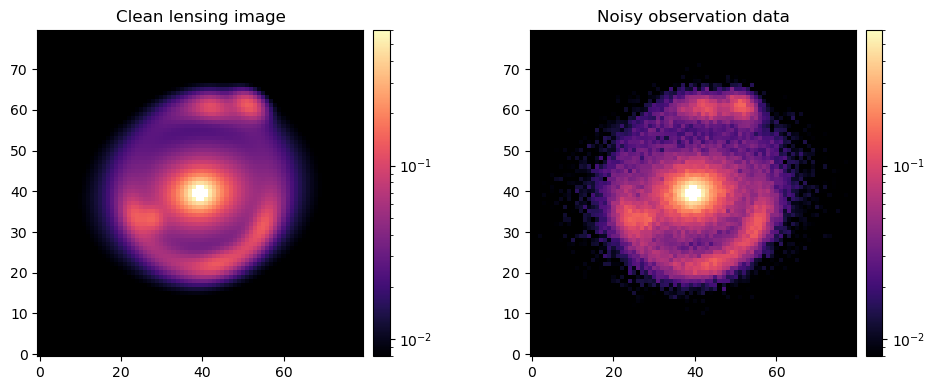

In [9]:
# visualize simulated products
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image")
img2 = ax2.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data")
plot_util.nice_colorbar(img2)
fig.tight_layout()
plt.show()

In [10]:
# Save data as FITS file
data_path = os.path.join('data', f"{object_name}.fits")
fits.writeto(data_path, data, overwrite=True)

### Arc mask

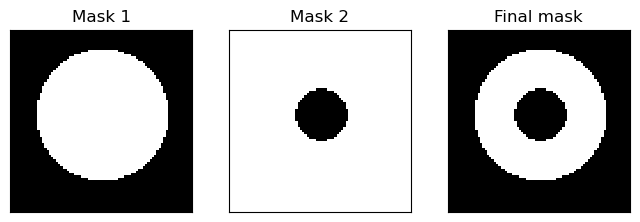

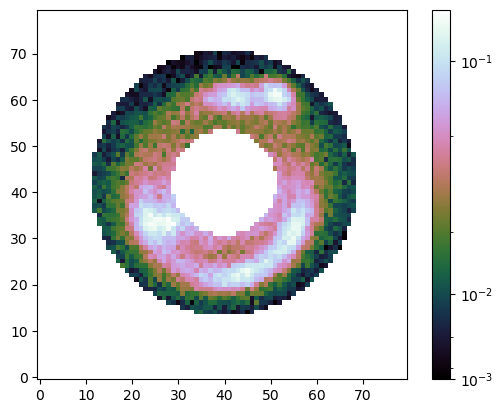

In [11]:
use_ds9_mask = False
mask_path = os.path.join('data', f"{object_name}_arcmask.reg")

if use_ds9_mask and not os.path.exists(mask_path):
    print(f"INFO: DS9 mask file {mask_path} does not exist!")

if use_ds9_mask and os.path.exists(mask_path):
    mask_path = os.path.join('data', f"{object_name}_arcmask.reg")
    regions = Regions.read(mask_path, format='ds9')
    arc_mask = (regions[0] ^ regions[1]).to_mask().to_image(data.shape)

else:
    # defines a suitable arc mask
    arc_mask_inner_radius = 0.9
    arc_mask_outer_radius = 2.3
    mask_center = (42*pix_scl, 40*pix_scl)
    mask_kwargs = {
        'mask_type_list': ['ellipse', 'circle'],
        'radius_list': [arc_mask_outer_radius] + [arc_mask_inner_radius], 
        'axis_ratio_list': [1] + [1],
        'angle_list': [0] + [0],
        'center_list': [mask_center] + [mask_center],
        'inverted_list': [False] + [True], 
        'operation_list': ['inter'],
    }

    image_mask_arc = ImageMask(
        mask_shape=(npix, npix),
        delta_pix=pix_scl,
        **mask_kwargs
    )
    arc_mask = image_mask_arc.get_mask(show_details=True)

if arc_mask is not None:
    data_masked = data.copy()
    data_masked[arc_mask == 0] = np.nan
    plt.imshow(data_masked, origin='lower',  cmap='cubehelix', norm=AsinhNorm(0.01, 1e-3))
    plt.colorbar()
    plt.show()

## Model the data

### PSF model

In [12]:
# Simply the same as the mock
psf_model = psf

### Noise model

In [13]:
noise_model = hcl.Noise(
    npix, npix, 
    background_rms=noise.background_rms, 
    exposure_time=noise.exposure_map,
)

### Mass model

In [14]:
# just the same as the input
lens_mass_model = hcl.MassModel(lens_mass_model_input.profile_type_list)

### Correlated field source model

In [15]:
num_source_pixels = NUM_PIX_SRC if not TEST_MODE else 10
source_light_model = hcl.LightModel(
    hcl.PixelatedLight(
        interpolation_type='fast_bilinear', 
        adaptive_grid=True,  # source grid extent will adapt using the arc mask
        allow_extrapolation=False,  # essentially says it should be zero outside the source grid
    ),
    kwargs_pixelated=dict(num_pixels=num_source_pixels),
)

# priors on the field
mean_source_intensity = 1e-2  # set it by hand based on the brightness of initial guess
source_field = hcl.CorrelatedField(
    "source_pixels", 
    source_light_model, 
    offset_mean=np.log(mean_source_intensity),  # take the log because exponentiate=True
    prior_offset_std=(0.5, 1e-6),
    prior_loglogavgslope=(-4., 0.5), 
    prior_fluctuations=(1.5, 0.8),
    prior_flexibility=None,
    prior_asperity=None,
    cropped_border_size=BORDER_FIELD_XY,
    exponentiate=True,
)

Exponential Cropped correlated field prior for 'source_pixels'


Below is just to visualize and play around with the source correlated field model.

In [16]:
pprint(kwargs_lens_input)

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'gamma': 2.0,
  'theta_E': 1.5},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
  'gamma2': Array(0.0285317, dtype=float64, weak_type=True),
  'ra_0': 0.0}]


In [17]:
pprint(kwargs_lens_light_input)

[{'R_sersic': 1.0,
  'amp': 8.0,
  'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'n_sersic': 3.0}]


In [18]:
kwargs_numerics_model = kwargs_numerics_simu
lens_image = hcl.LensImage(
    pixel_grid, 
    psf_model,
    noise_class=noise_model, 
    lens_mass_model_class=lens_mass_model,
    lens_light_model_class=deepcopy(lens_light_model_input),
    source_model_class=source_light_model, 
    source_arc_mask=arc_mask.astype(bool),
    kwargs_numerics=kwargs_numerics_model,
)

In [19]:
if FIX_SLOPE:
    fixed_gamma = gamma_input
    
class ProbModel(hcl.NumpyroModel):
    
    def model(self):
        # Parameters of the source
        prior_source = [
            {
                'pixels': source_field.numpyro_sample_pixels(),
            }
        ]

        # Parameters of the lens light that are used for the lens mass
        cx = numpyro.sample('light_cx', dist.Normal(kwargs_lens_light_input[0]['center_x'], 2*pix_scl))
        cy = numpyro.sample('light_cy', dist.Normal(kwargs_lens_light_input[0]['center_x'], 2*pix_scl))
        # e1 = numpyro.sample('light_e1', dist.TruncatedNormal(kwargs_lens_input[0]['e1'], 0.08, low=-0.3, high=0.3))
        # e2 = numpyro.sample('light_e2', dist.TruncatedNormal(kwargs_lens_input[0]['e2'], 0.08, low=-0.3, high=0.3))
        e1 = numpyro.sample('light_e1', dist.Normal(kwargs_lens_input[0]['e1'], 0.08))
        e2 = numpyro.sample('light_e2', dist.Normal(kwargs_lens_input[0]['e2'], 0.08))

        # Parameters of the lens light, with center relative the lens mass
        prior_lens_light = kwargs_lens_light_input  # comment and uncomment below to unfix lens light parameters
        # Here we on-purpose put very tight priors to prevent the random initial guess to destroy chi2
        # prior_lens_light = [
        #     {
        #         'amp': numpyro.sample('light_amp', dist.TruncatedNormal(kwargs_lens_light_input[0]['amp'], 0.5, low=0.1, high=20.)),
        #         'R_sersic': numpyro.sample('light_R_sersic', dist.TruncatedNormal(kwargs_lens_light_input[0]['R_sersic'], 0.05, low=0.05, high=2.)),
        #         'n_sersic': numpyro.sample('light_n_sersic', dist.Uniform(0.5, high=5.)),
        #         'e1': e1,
        #         'e2': e2,
        #         'center_x': cx, 
        #         'center_y': cy,
        #     }
        # ]

        prior_lens = [
            # power-law
            {
                'theta_E': numpyro.sample(
                    'lens_theta_E', dist.Uniform(kwargs_lens_input[0]['theta_E']-0.03, kwargs_lens_input[0]['theta_E']+0.03)
                ),
                'e1': e1,
                'e2': e2,
                'center_x': cx, 
                'center_y': cy,
            },
            # external shear, with fixed origin
            {
                # 'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_lens_input[1]['gamma1'], 0.08, low=-0.3, high=0.3)), 
                # 'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_lens_input[1]['gamma2'], 0.08, low=-0.3, high=0.3)), 
                'gamma1': numpyro.sample('lens_gamma1', dist.Normal(kwargs_lens_input[1]['gamma1'], 0.08)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.Normal(kwargs_lens_input[1]['gamma2'], 0.08)), 
                'ra_0': 0.0, 
                'dec_0': 0.0,
            }
        ]
        if FIX_SLOPE:
            prior_lens[0]['gamma'] = fixed_gamma
        else:
            prior_lens[0]['gamma'] = numpyro.sample('lens_gamma', dist.TruncatedNormal(kwargs_lens_input[0]['gamma'], 0.1, 1.5, 2.5))
        
        # wrap up all parameters for the lens_image.model() method
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light=prior_lens_light,
                            kwargs_source=prior_source)
        
        # generates the model image
        model_image = lens_image.model(**model_params)
        
        # estimate the error per pixel
        model_var = noise.C_D_model(model_image)
        model_std = jnp.sqrt(model_var)
        
        # finally defines the observed node, conditioned on the data assuming a Gaussian distribution
        numpyro.sample('obs', dist.Independent(dist.Normal(model_image, model_std), 2), obs=data)
    
    def params2kwargs(self, params):
        # Pack the parameters for Herculens
        # Lens mass
        #e1_conv, e2_conv = param_util.phi_q2_ellipticity(params['lens_phi'], params['lens_q'])
        kwargs_lens = [
            {
                'theta_E': params['lens_theta_E'],
                'e1': params['light_e1'], 
                'e2': params['light_e2'],
                'center_x': params['light_cx'], 
                'center_y': params['light_cy'], 
            },
            {
                'gamma1': params['lens_gamma1'], 
                'gamma2': params['lens_gamma2'], 
            }
        ]
        if FIX_SLOPE:
            kwargs_lens[0]['gamma'] = fixed_gamma
        else:
            kwargs_lens[0]['gamma'] = params['lens_gamma']
        
        # Lens light
        kwargs_lens_light = kwargs_lens_light_input  # comment and uncomment below to unfix lens light parameters
        # kwargs_lens_light = [
        #     {
        #         'amp': params['light_amp'],
        #         'R_sersic': params['light_R_sersic'],
        #         'n_sersic': params['light_n_sersic'],
        #         'e1': params['light_e1'], 
        #         'e2': params['light_e2'],
        #         'center_x': params['light_cx'],
        #         'center_y': params['light_cy'],
        #     },
        # ]

        # Source light
        #params_source_pixels = source_field_model(params)['source_pixels']  # weird syntax I know
        params_source_pixels = source_field.model(params)
        kwargs_source = [{'pixels': params_source_pixels}]
        return dict(kwargs_lens=kwargs_lens, 
                    kwargs_lens_light=kwargs_lens_light, 
                    kwargs_source=kwargs_source)

prob_model = ProbModel()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

Number of parameters: 2510


In [20]:
# visualize the probabilistic graph thanks to NumPyro utility
#prob_model.render_model()

In [21]:
def visualize_initial_guess(init_params):
    # Evaluate the model
    initial_model = lens_image.model(**prob_model.params2kwargs(init_params))

    # visualize initial guess
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    ax = axes[0]
    ax.set_title("Initial guess model")
    im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
    plot_util.nice_colorbar(im)
    ax = axes[1]
    ax.set_title("Data")
    im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
    plot_util.nice_colorbar(im)
    ax = axes[2]
    ax.set_title("Difference")
    im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
    plot_util.nice_colorbar(im)
    fig.tight_layout()
    plt.show()

In [22]:
# Draw a random initial guess from the prior
prng_key = jax.random.PRNGKey(SEED_INIT)
prng_key, prng_key_init = jax.random.split(prng_key)
# init_params = prob_model.get_sample(prng_key=prng_key_init)  # constrained space
# init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space

# run num_start optimisations in parallel with independent seeds
num_start = NUM_START if not TEST_MODE else 2
prng_keys_optim = jax.random.split(prng_key_init, num_start)

In [23]:
# Define the optimizer
loss = hcl.Loss(prob_model)
optimizer = hcl.OptaxOptimizer(loss, loss_norm_optim=data.size)

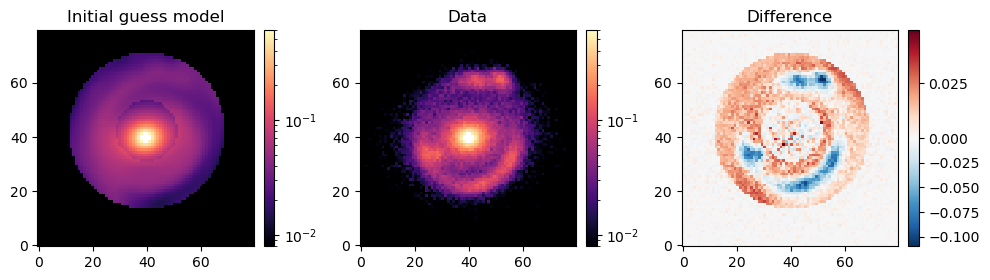

Initial loss for start 0 = -10582.427030617184


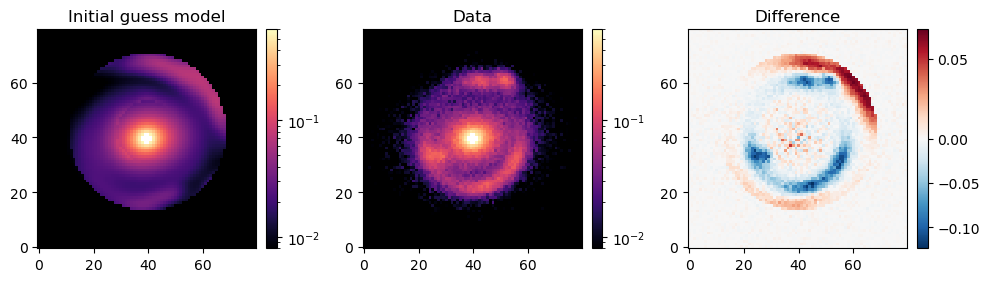

Initial loss for start 1 = 19466.395500831473


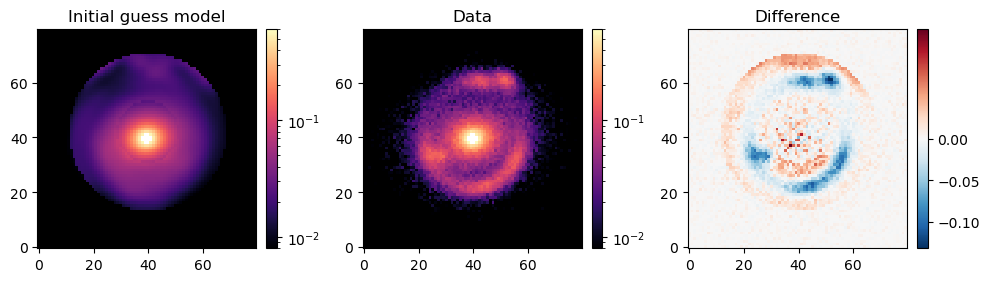

Initial loss for start 2 = -1283.8555901574864


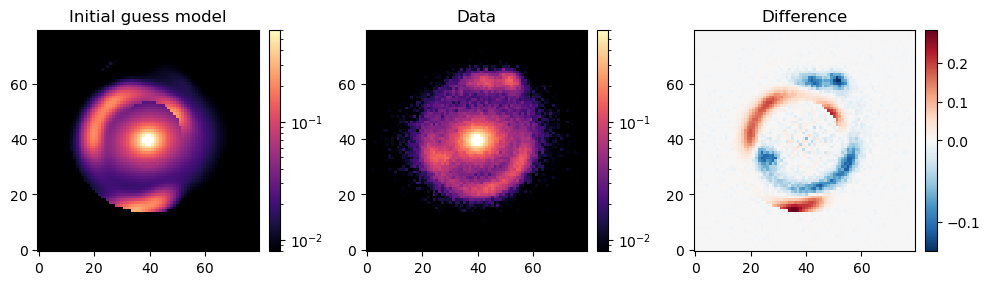

Initial loss for start 3 = 34419.00425271003


In [24]:
# Have a look at the initial guesses
for i, key in enumerate(prng_keys_optim):
    init_params = prob_model.get_sample(prng_key=key)
    visualize_initial_guess(init_params)
    print(f"Initial loss for start {i} =", loss(prob_model.unconstrain(init_params)))

In [25]:
# optimizer settings
max_iterations = 2_000 if not TEST_MODE else 100
init_learning_rate = 5e-3
algorithm = 'adabelief'

@jax.vmap
def map_optim(key):
    # draw parameters in unconstrained space
    init_unconst = prob_model.unconstrain(
        prob_model.get_sample(prng_key=key)
    )
    # run optimizer
    best_fit_unconst, logL, extra_fields, runtime = optimizer.run(
        init_unconst, 
        algorithm=algorithm,
        max_iterations=max_iterations, 
        init_learning_rate=init_learning_rate,
        progress_bar=True,
    )
    # return the constrained parameters values
    best_fit = prob_model.constrain(best_fit_unconst)
    return best_fit, logL, extra_fields, runtime

In [26]:
# best_fit, logL, extra_fields, runtime \
#     = optimizer.run(init_params_unconst, max_iterations=max_iterations, 
#                     init_learning_rate=init_learning_rate)
# print(f"Runtime for each chain: {runtime}")
# print("Loss at best-fit:", loss(best_fit))

multi_best_fit, multi_logL, multi_extra_fields, multi_runtime = map_optim(prng_keys_optim)
print("Optimisation runtime for each start:", multi_runtime)

optax.adabelief: 100%|██████████| 2000/2000 [02:15<00:00, 14.73it/s]


Optimisation runtime for each start: [135.77479482 135.77479482 135.77479482 135.77479482]


Best run: 0


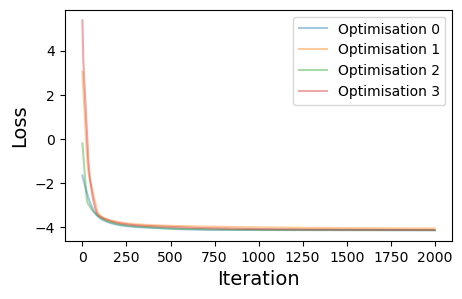

In [105]:
# index of the best model from the multi-start optimisation
idx_best_start = int(np.argmax(multi_logL))
print("Best run:", idx_best_start)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for i in range(num_start):
    ax.plot(
        range(len(multi_extra_fields['loss_history'][i])), 
        multi_extra_fields['loss_history'][i], 
        label=f"Optimisation {i}",
        alpha=0.4,
    )
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.legend()
plt.show()

In [28]:
@jax.jit
def get_value_from_index(xs, i):
    """useful helper function for unstacking vmap'ed results"""
    return jax.tree.map(lambda x: x[i], xs)

Final loss for start 0 = -26459.500961024387


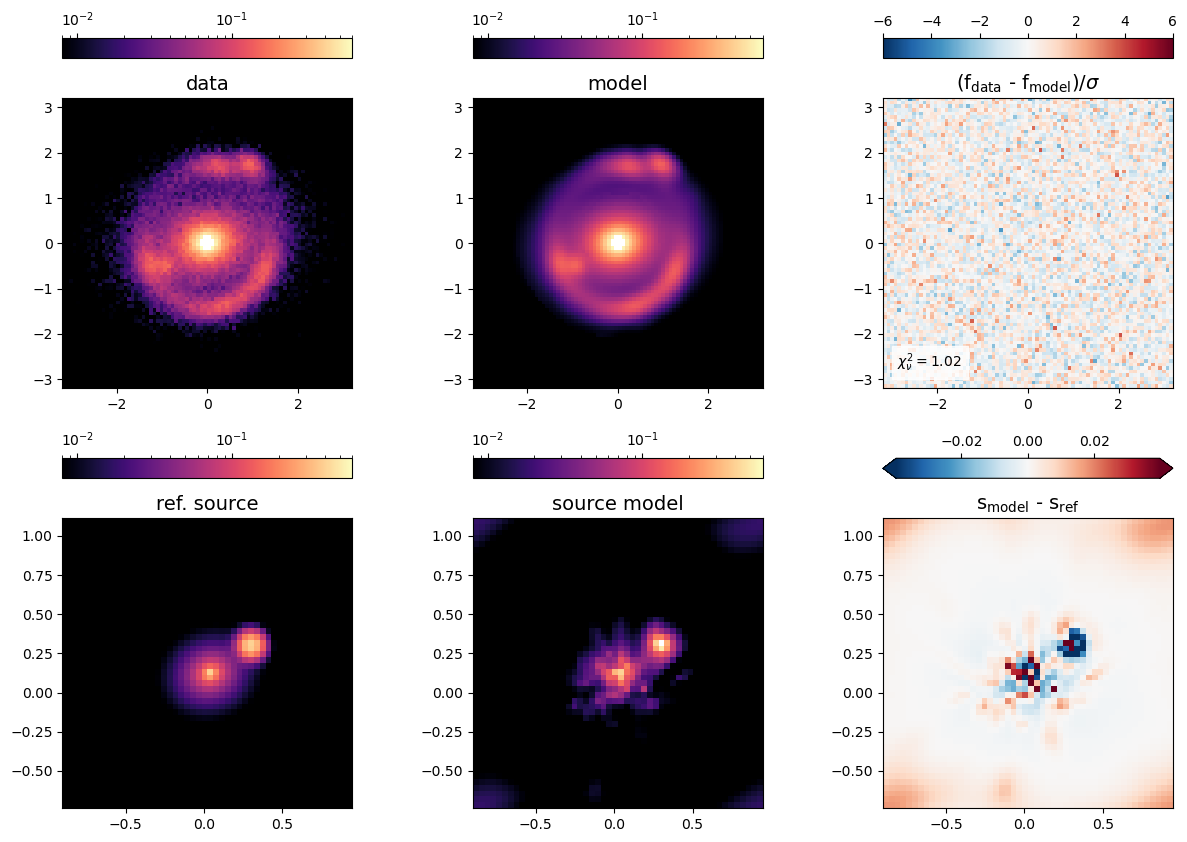

Final loss for start 1 = -25933.00853882384


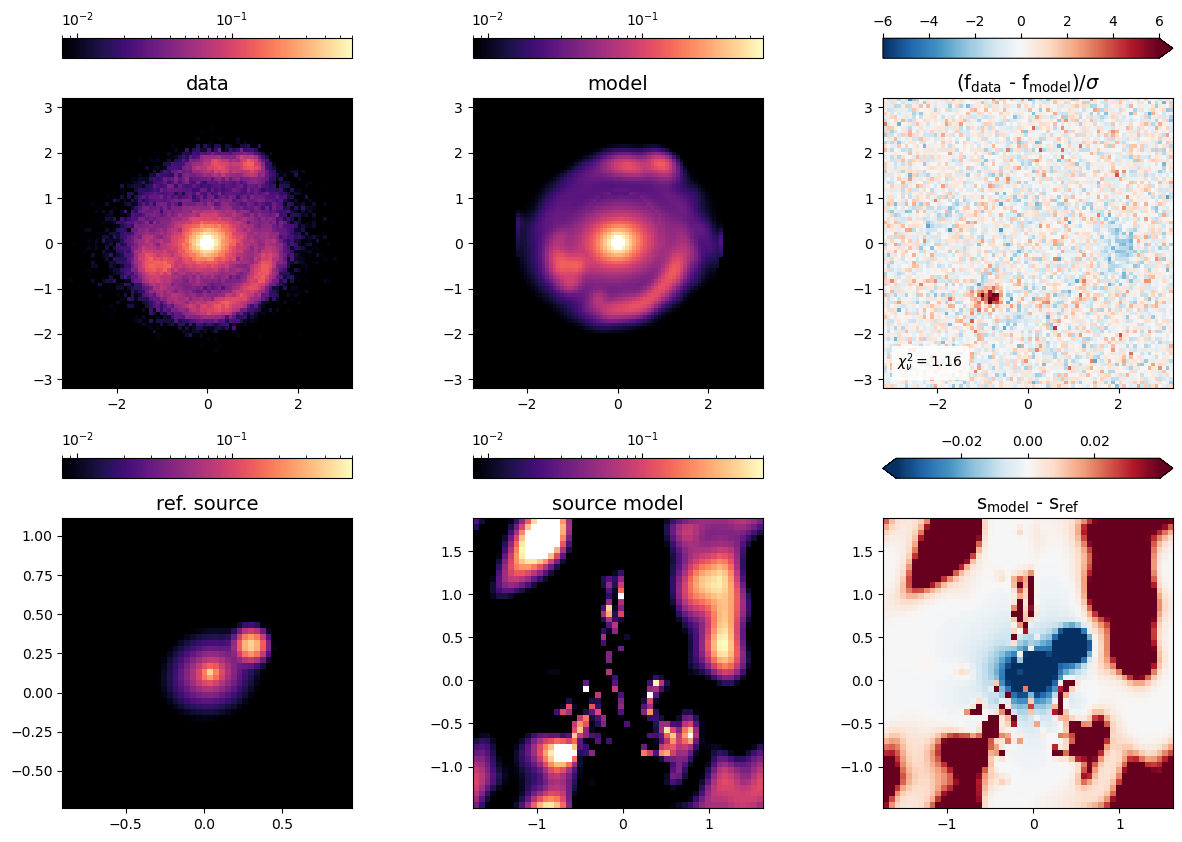

Final loss for start 2 = -26429.05581532829


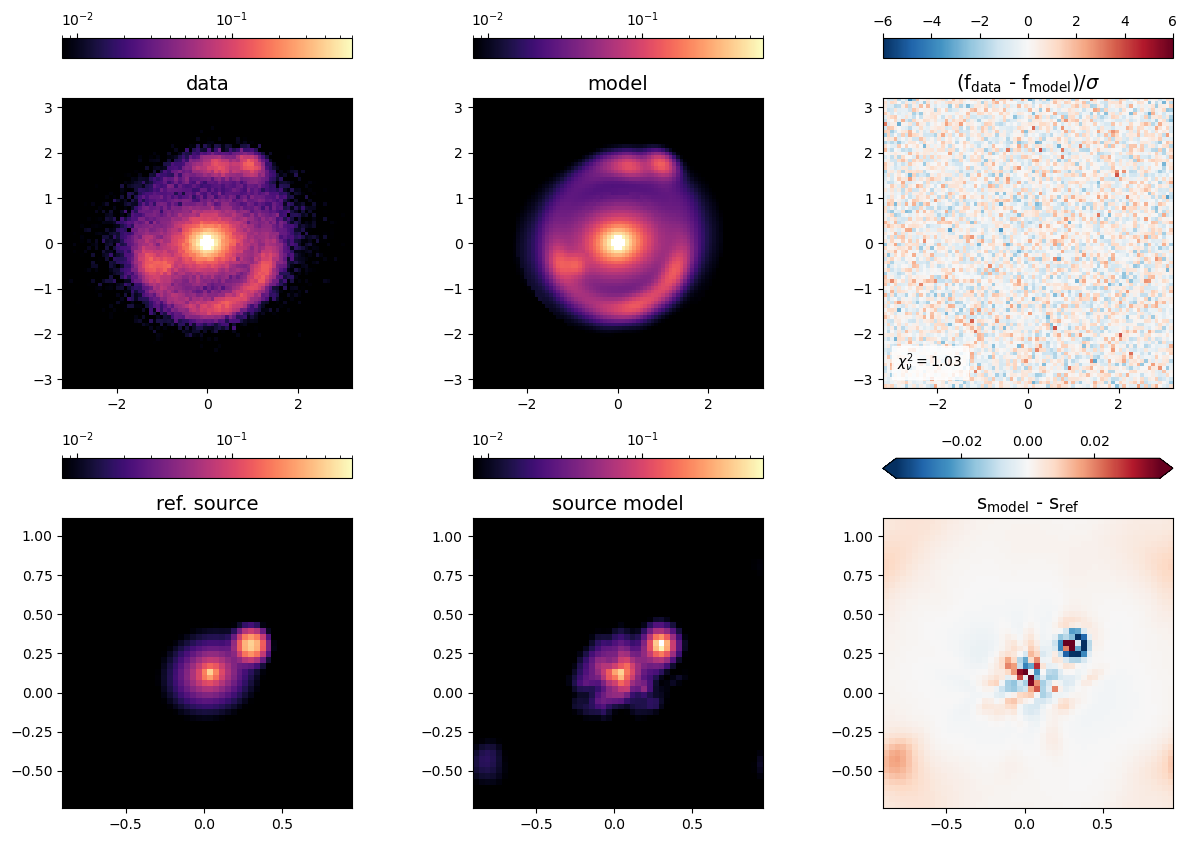

Final loss for start 3 = -26403.094824097654


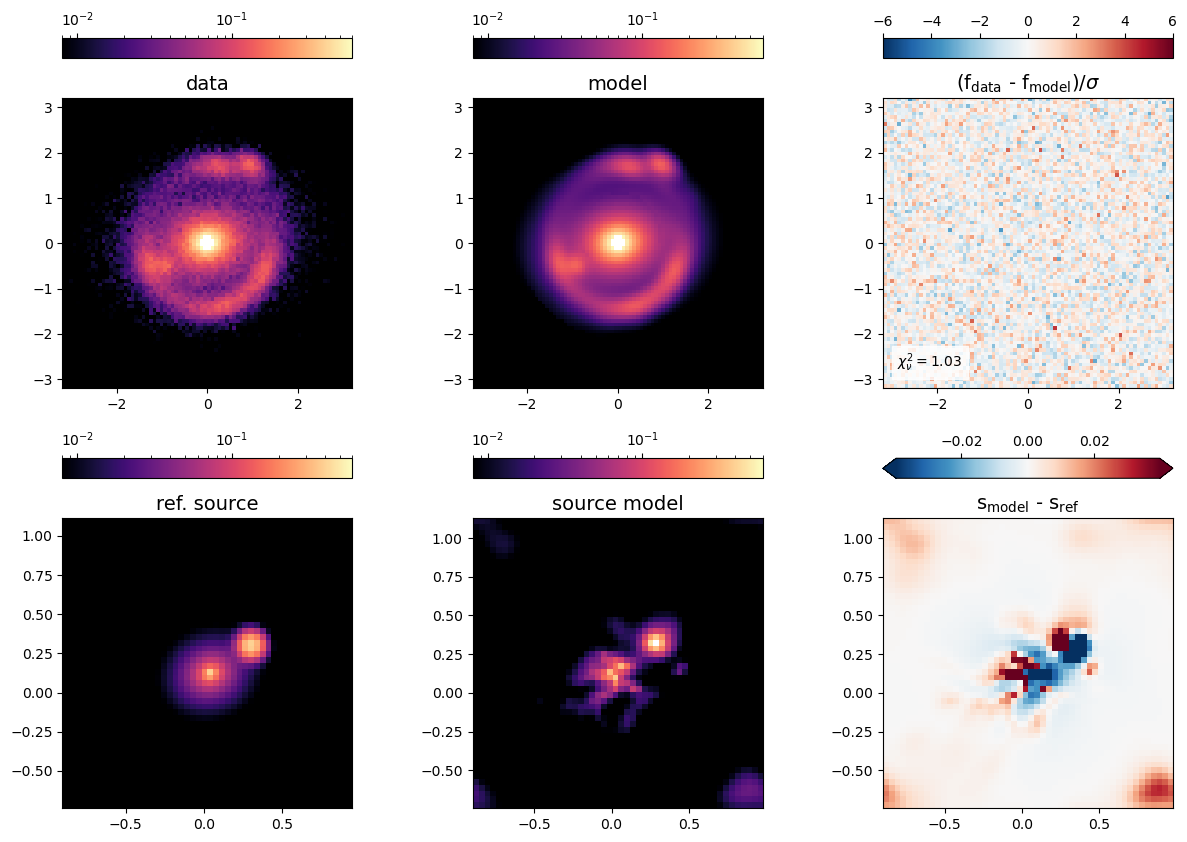

In [29]:
# first we set the reference source on the same grid as the modelled source
some_best_fit_kwargs = prob_model.params2kwargs(get_value_from_index(multi_best_fit, 0))
x_grid_src, y_grid_src, src_extent = lens_image.get_source_coordinates(
        some_best_fit_kwargs['kwargs_lens'], return_plt_extent=True
    )
source_input_on_model_grid = lens_image_simu.eval_source_surface_brightness(
    x_grid_src, y_grid_src, 
    kwargs_source_input, 
    kwargs_lens=some_best_fit_kwargs['kwargs_lens'], 
    de_lensed=True,
)
source_input_on_model_grid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_on_model_grid, plt_extent=src_extent)

for i in range(num_start):
    best_fit_i = get_value_from_index(multi_best_fit, i)
    print(f"Final loss for start {i} =", loss(prob_model.unconstrain(best_fit_i)))

    _ = plotter.model_summary(
        lens_image, 
        prob_model.params2kwargs(best_fit_i), 
        #kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
        show_source=True)
    plt.show()

## Estimate the posterior with SVI

In [30]:
best_start_optim = prob_model.get_sample(prng_key=prng_keys_optim[idx_best_start])  # same starting point as the best optimisation result
best_fit_optim = get_value_from_index(multi_best_fit, idx_best_start) # best result from the multi-start optimisation step

print(best_start_optim['lens_theta_E'])
print(best_fit_optim['lens_theta_E'])
print(best_start_optim['light_cx'])
print(best_fit_optim['light_cx'])

1.4725092198560106
1.4997236485933492
0.16978147912261196
-0.009220675446959066


In [31]:
num_chains = NUM_CHAINS if not TEST_MODE else 2
# This can be adjusted as needed to get decent SVI results
max_iterations_svi = 2_000 if not TEST_MODE else 100

# Initialization of SVI
# init_fun_svi = infer.init_to_median(num_samples=25) # start from the median of prior
init_fun_svi = infer.init_to_value(
    values=best_start_optim,
)  # start at the given parameters values

# NOTE: it seems it's better to start from a the best initial guess,
# rather that the best fit from the optimisation... 
# Probably the SVI simply fails at finding something even better.

# Model (likelihoods and priors)
model_svi = prob_model.model

# Guide (posterior model)
guide_svi = autoguide.AutoLowRankMultivariateNormal(
    model_svi,
    init_loc_fn=init_fun_svi
)

# This is just an example scheduler
# playing around with `transition_steps` can help
# the SVI results
scheduler = optax.exponential_decay(
    init_value=0.01,
    decay_rate=0.99,
    transition_steps=50
)

# Other optimizations functions might work better for your
# problem, adabelief worked best for ours
optim_svi = optax.adabelief(learning_rate=scheduler)
loss_svi = infer.TraceMeanField_ELBO(num_particles=1)

# make the SVI class object
svi = infer.SVI(
    model_svi,
    guide_svi,
    optim_svi,
    loss_svi,
)

In [32]:
# take in a list of random keys and do one SVI run for each
@jax.vmap
def map_svi(key):
    return svi.run(
        key,
        max_iterations_svi,
        # data,  # data is already in the model so we don't pass it here
        progress_bar=False,
        stable_update=False,  # Coleman uses True here, but some of our parameters do not like that apparently 
    )

# make a random key and split it
prng_key, prng_key_svi = jax.random.split(prng_key)

# run num_chains SVI's in parallel with independent seeds
svi_keys = jax.random.split(prng_key_svi, num_chains)
multi_svi_results = map_svi(svi_keys)

/Users/aymgal/miniconda3/envs/herculens312jaxinf/lib/python3.12/site-packages/jax/_src/linear_util.py:192: UserWarning: Failed to verify mean field restriction on the guide. To eliminate this warning, ensure model and guide sites occur in the same order.
Model sites:
  source_pixels_field_xi
  source_pixels_field_xy_dim_fluctuations
  source_pixels_field_xy_dim_loglogavgslope
  source_pixels_field_zeromode
  light_cx
  light_cy
  light_e1
  light_e2
  lens_theta_E
  lens_gamma1
  lens_gamma2Guide sites:
  lens_gamma1
  lens_gamma2
  lens_theta_E
  light_cx
  light_cy
  light_e1
  light_e2
  source_pixels_field_xi
  source_pixels_field_xy_dim_fluctuations
  source_pixels_field_xy_dim_loglogavgslope
  source_pixels_field_zeromode
  ans = self.f(*args, **dict(self.params, **kwargs))


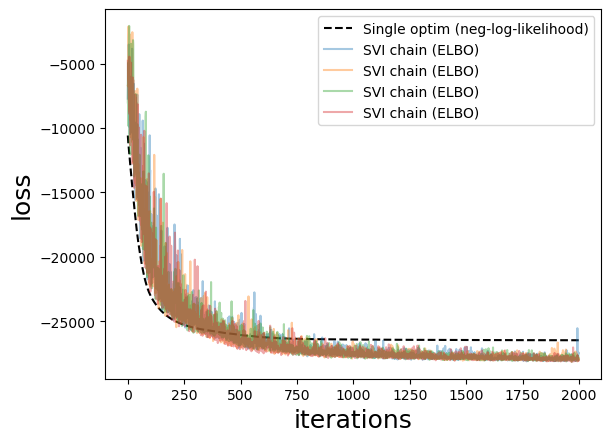

In [33]:
# check convergence of ELBO loss
plt.plot(range(len(multi_extra_fields['loss_history'][idx_best_start])), 
         multi_extra_fields['loss_history'][idx_best_start] * data.size,   # de-normalise the optimisation loss here 
        linestyle='--', color='black', label="Single optim (neg-log-likelihood)")
plt.plot(multi_svi_results.losses.T, alpha=0.4, label="SVI chain (ELBO)")
plt.xlabel("iterations", fontsize=18)
plt.ylabel("loss", fontsize=18)
plt.legend()
plt.show()

In [34]:
# get the median of each SVI chain
multi_svi_median = guide_svi.median(multi_svi_results.params)

In [35]:
# Convert the median SVI results to the unconstrained space
multi_svi_median_unconst = jax.vmap(
    lambda p: infer.util.unconstrain_fn(model_svi, (), {}, p)
)(
    multi_svi_median
)

In [36]:
print(f"Initial SVI loss = {loss(prob_model.unconstrain(best_start_optim))}")
print(f"Final loss from optimisation = {loss(prob_model.unconstrain(best_fit_optim))}")
for i in range(num_chains):
    svi_median_i = get_value_from_index(multi_svi_median_unconst, i)
    print(f"Final loss for SVI chain {i} = {loss(svi_median_i)}")

Initial SVI loss = -10582.427030617184
Final loss from optimisation = -26459.500961024387
Final loss for SVI chain 0 = -25837.046688138467
Final loss for SVI chain 1 = -26115.07799816648
Final loss for SVI chain 2 = -26170.540558946657
Final loss for SVI chain 3 = -26158.520641450214


SVI CHAIN 0


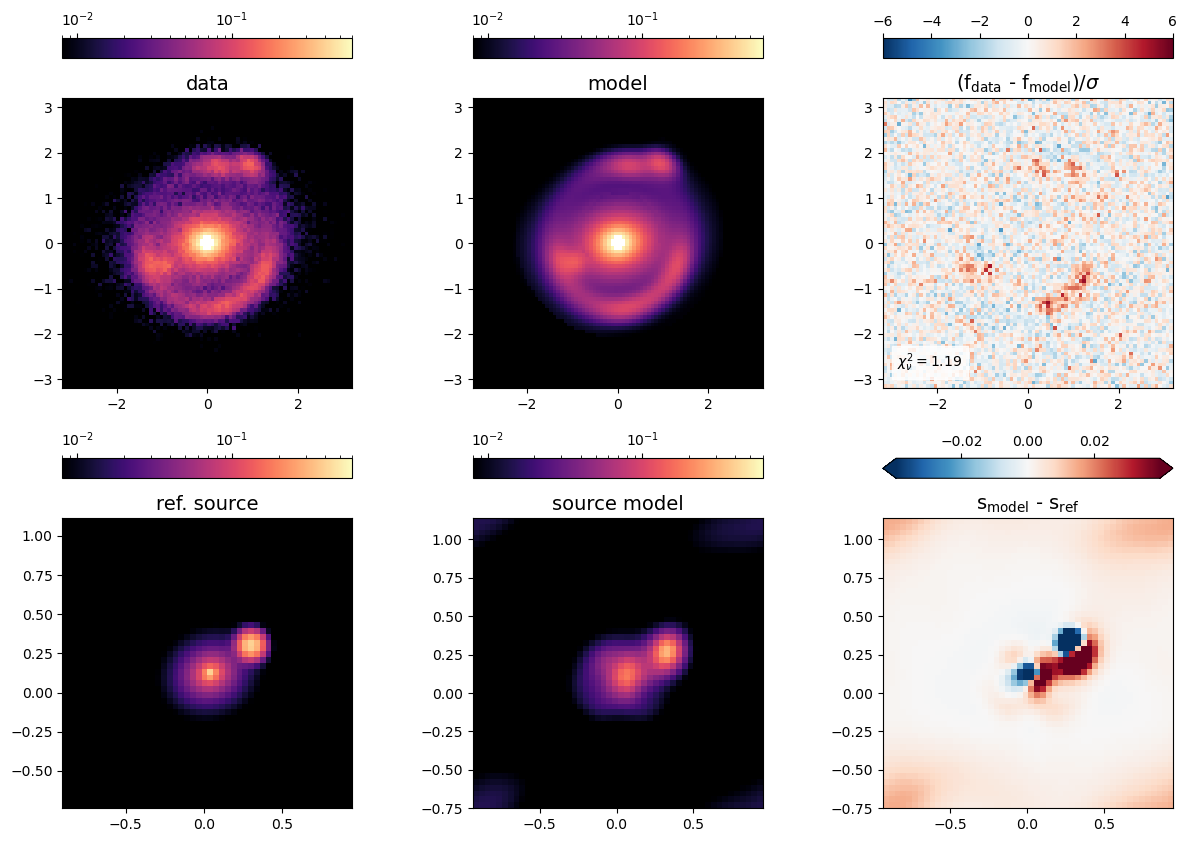

SVI CHAIN 1


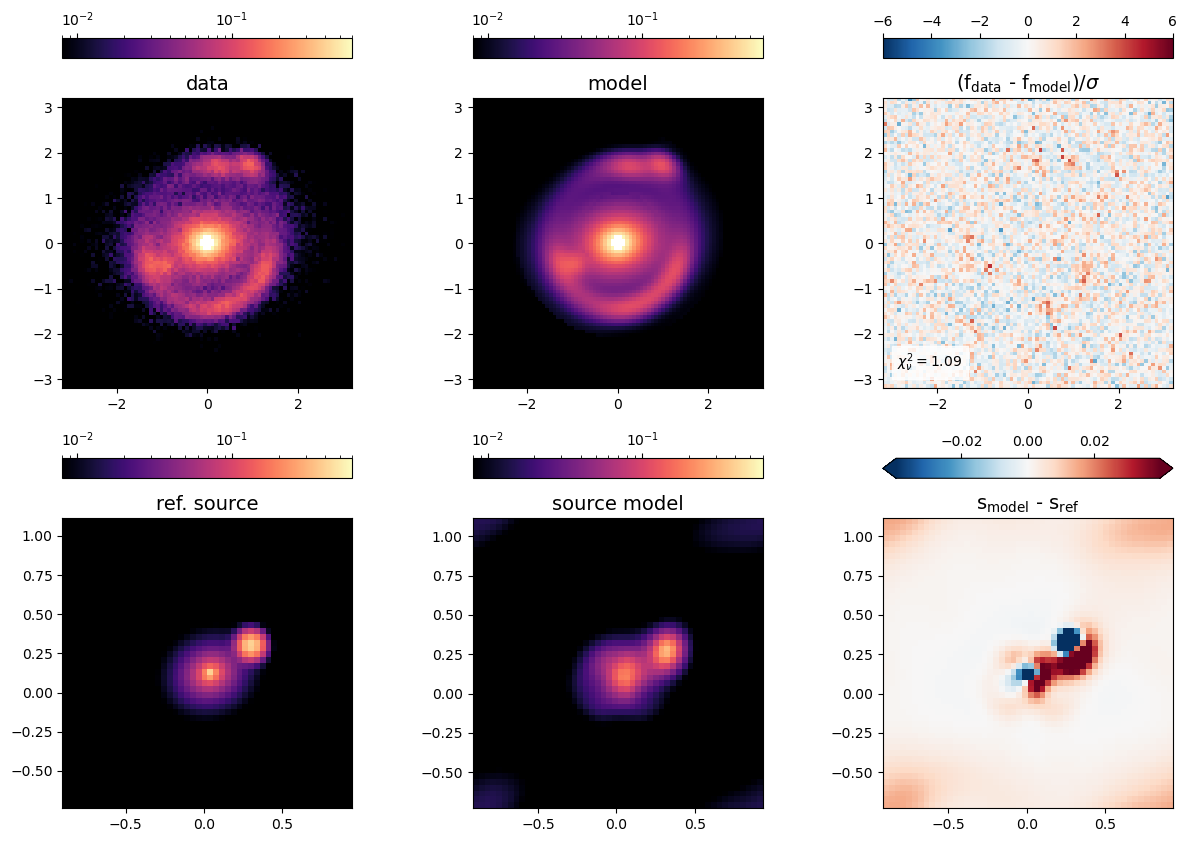

SVI CHAIN 2


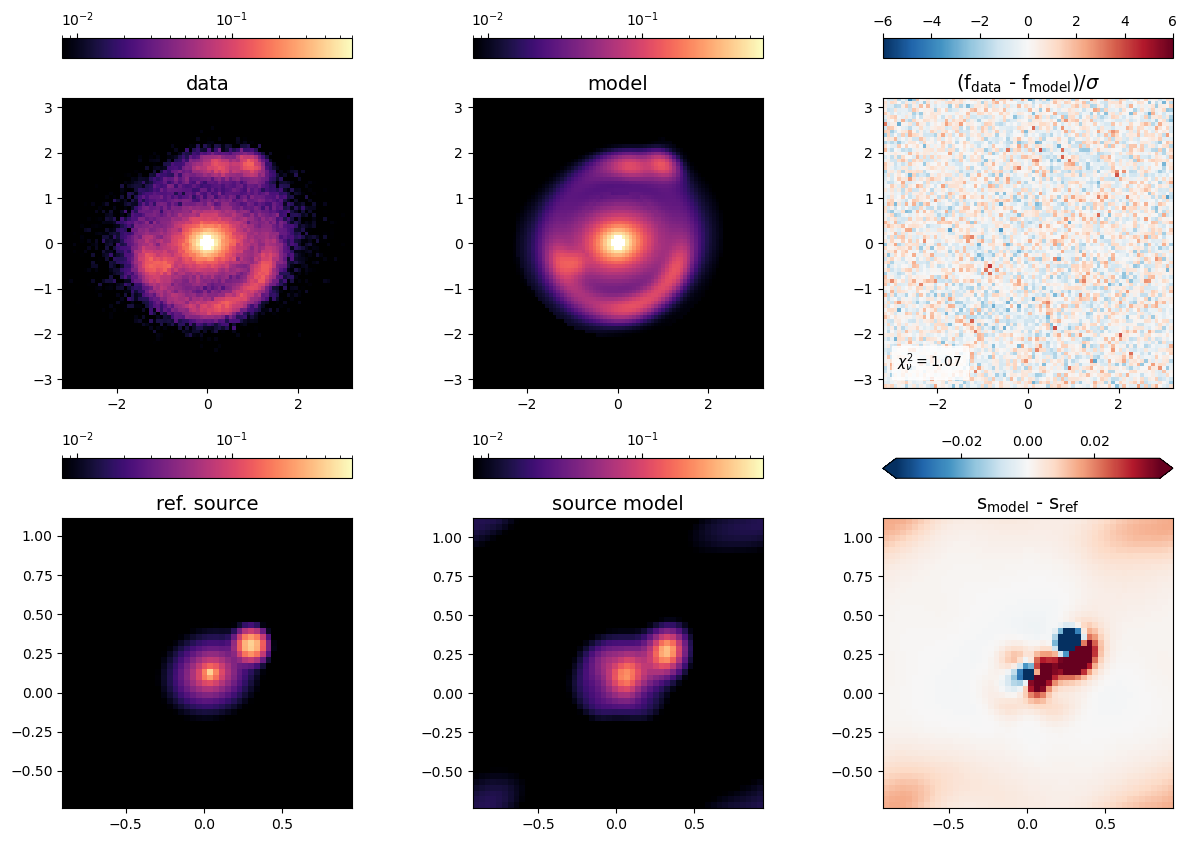

SVI CHAIN 3


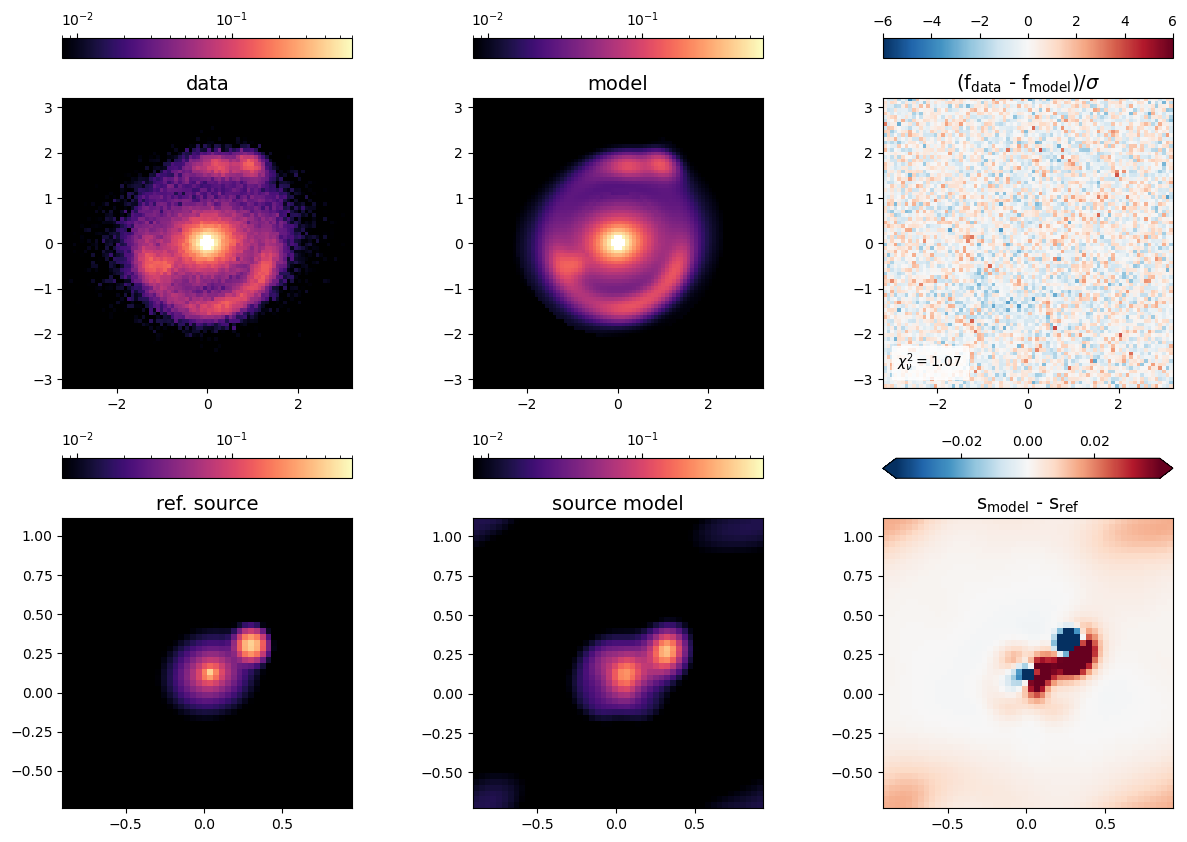

In [37]:
# NOTE: the displayed models below are the *median* SVI models! These are not best-fit whatsoever
# (so cannot be fairly compared to the best-fit from optimisation)
for i in range(num_chains):
    print(f"SVI CHAIN {i}")
    kwargs_svi_i = prob_model.params2kwargs(get_value_from_index(multi_svi_median, i))

    fig = plotter.model_summary(lens_image, 
                                kwargs_svi_i, 
                                #kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
                                show_source=True)
    plt.show()

In [38]:
if not RUN_HMCGIBBS:
    raise

## Sample the posterior with HMC-within-Gibbs

This is a multi-step version of HMC, where a subset of parameters is fixed while being conditioned on other sampled parameters. This process is performed a few times.

In [39]:
parameter_names = list(init_params.keys())
pprint(parameter_names)

['source_pixels_field_xi',
 'source_pixels_field_xy_dim_fluctuations',
 'source_pixels_field_xy_dim_loglogavgslope',
 'source_pixels_field_zeromode',
 'light_cx',
 'light_cy',
 'light_e1',
 'light_e2',
 'lens_theta_E',
 'lens_gamma1',
 'lens_gamma2']


**Note**: Below we use the automatic adaptation of the mass matrix for the HMC/NUTS samplers. To help further the algorithm, it is common to set the mass matrix to the inverse parameters covariance matrix estimated from the SVI chains above. 

In [40]:
num_warmup_hmc = 100 if not TEST_MODE else 10
num_samples_hmc = 200 if not TEST_MODE else 10

model_hmc = prob_model.model  # numpyro model
init_fun_hmc = infer.init_to_value(
    values=get_value_from_index(multi_svi_median, 0)  # should be in UNconstrained space
)  # this will be overwritten afterward anyway
inner_kernels = [
    NUTS(
        model_hmc,
        inverse_mass_matrix=None, 
        adapt_step_size=True, 
        adapt_mass_matrix=True, 
        dense_mass=False, 
        target_accept_prob=0.8, 
        trajectory_length=None, 
        max_tree_depth=10, 
        init_strategy=init_fun_hmc,
    ),
    NUTS(
        model_hmc,
        inverse_mass_matrix=None, 
        adapt_step_size=True, 
        adapt_mass_matrix=True, 
        dense_mass=False, 
        target_accept_prob=0.8, 
        trajectory_length=None, 
        max_tree_depth=10, 
        init_strategy=init_fun_hmc,
    ),
]

gibbs_sites_list = [
    # We first sample the lens parameters (conditioned on the source)
    [
        'light_cx',
        'light_cy',
        'light_e1',
        'light_e2',
        'lens_theta_E',
        'lens_gamma1',
        'lens_gamma2'
    ],
    # then we sample the source parameters (conditioned on the lens)
    [
        'source_pixels_field_xi',
        'source_pixels_field_xy_dim_fluctuations',
        'source_pixels_field_xy_dim_loglogavgslope',
        'source_pixels_field_zeromode'
    ],
]
if not FIX_SLOPE:
    gibbs_sites_list[0].append('lens_gamma')

outer_kernel = MultiHMCGibbs(
    inner_kernels,
    gibbs_sites_list,
)

mcmc = MCMC(
    outer_kernel,
    num_warmup=num_warmup_hmc,
    num_samples=num_samples_hmc,
    progress_bar=True,
    num_chains=num_chains,
    chain_method='vectorized',
)

In [41]:
# split key one more time and initialize each chian with an
# *independent* SVI result
prng_key, rng_key_hmc = jax.random.split(prng_key)
mcmc.run(
    rng_key_hmc,
    init_params=multi_svi_median_unconst,  # should be in UNconstrained space
)

sample: 100%|██████████| 300/300 [57:08<00:00, 11.43s/it] 


In [42]:
mcmc.print_summary()


                                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
                                lens_gamma1     -0.00      0.01     -0.00     -0.01      0.01     13.38      1.42
                                lens_gamma2      0.02      0.00      0.02      0.02      0.03     24.06      1.25
                               lens_theta_E      1.50      0.00      1.50      1.50      1.51     20.27      1.25
                                   light_cx     -0.01      0.00     -0.01     -0.02     -0.00     24.36      1.28
                                   light_cy     -0.00      0.00     -0.00     -0.01      0.01     21.20      1.25
                                   light_e1      0.15      0.01      0.15      0.13      0.17     12.85      1.48
                                   light_e2      0.03      0.01      0.03      0.02      0.04     25.27      1.24
                source_pixels_field_xi[0,0]     -4.31      0.35     -4.27     -4.79    

In [43]:
hmcgibbs_samples = mcmc.get_samples()
hmcgibbs_samples_as_kwargs = jax.vmap(lambda x: prob_model.params2kwargs(x))(hmcgibbs_samples)

In [44]:
hmcgibbs_samples['lens_theta_E'].mean(), hmcgibbs_samples_as_kwargs['kwargs_lens'][0]['theta_E'].mean()

(Array(1.50136634, dtype=float64), Array(1.50136634, dtype=float64))

In [45]:
hmcgibbs_samples_as_kwargs['kwargs_lens'][0]['theta_E']

Array([1.50237859, 1.50129941, 1.50239435, 1.50257366, 1.50286973,
       1.50285822, 1.5018637 , 1.50158125, 1.50193575, 1.50235308,
       1.50211037, 1.50210962, 1.50098624, 1.50141007, 1.50416133,
       1.50453022, 1.50438838, 1.50455047, 1.50513531, 1.50590912,
       1.50594682, 1.50554065, 1.50252958, 1.50295474, 1.50364026,
       1.50352501, 1.50359214, 1.50352056, 1.50208333, 1.50098767,
       1.50122706, 1.50133278, 1.50082686, 1.50123642, 1.50385971,
       1.50328191, 1.50534684, 1.50639301, 1.50563121, 1.50276523,
       1.50334914, 1.50236045, 1.50198371, 1.50209203, 1.50205316,
       1.50404374, 1.5052656 , 1.50374731, 1.50380767, 1.50384475,
       1.50361353, 1.5032558 , 1.49965753, 1.50225426, 1.50288679,
       1.50359296, 1.50418915, 1.50486522, 1.50485857, 1.50438965,
       1.50424936, 1.50408768, 1.50379421, 1.5000703 , 1.49767207,
       1.50202772, 1.50257332, 1.50246902, 1.50160854, 1.50181737,
       1.49989205, 1.49995202, 1.50121259, 1.50090206, 1.50150

In [46]:
inf_data_hmc = az.from_numpyro(mcmc)
print(f'divergences per chain per step:\n {inf_data_hmc.sample_stats.diverging.values.sum(axis=1).T}')
display(az.summary(inf_data_hmc))


divergences per chain per step:
 [[0 0 0 0]
 [0 0 0 0]]


mean     sd  hdi_3%  hdi_97%  \
lens_gamma1                               -0.004  0.006  -0.014    0.007   
lens_gamma2                                0.024  0.004   0.016    0.032   
lens_theta_E                               1.501  0.003   1.495    1.509   
light_cx                                  -0.008  0.005  -0.017    0.000   
light_cy                                  -0.002  0.004  -0.009    0.007   
...                                          ...    ...     ...      ...   
source_pixels_field_xi[49, 48]             0.099  0.637  -1.118    1.315   
source_pixels_field_xi[49, 49]             0.286  0.417  -0.438    1.078   
source_pixels_field_xy_dim_fluctuations    0.484  0.306  -0.069    1.095   
source_pixels_field_xy_dim_loglogavgslope  1.519  0.457   0.743    2.503   
source_pixels_field_zeromode              -0.051  1.017  -1.856    1.869   

                                           mcse_mean  mcse_sd  ess_bulk  \
lens_gamma1                                    0.002    0.001       9.0   
lens_gamma2                                    0.001    0.001      14.0   
lens_theta_E                                   0.001    0.001      13.0   
light_cx                                       0.001    0.001      13.0   
light_cy                                       0.001    0.001      12.0   
...                                              ...      ...       ...   
source_pixels_field_xi[49, 48]                 0.024    0.019     719.0   
source_pixels_field_xi[49, 49]                 0.015    0.012     760.0   
source_pixels_field_xy_dim_fluctuations        0.018    0.013     299.0   
source_pixels_field_xy_dim_loglogavgslope      0.025    0.017     342.0   
source_pixels_field_zeromode                   0.030    0.037    1158.0   

                                           ess_tail  r_hat  
lens_gamma1                                    18.0   1.40  
lens_gamma2                                    60.0   1.23  
lens_theta_E                                   28.0   1.25  
light_cx                                       86.0   1.28  
light_cy                                       46.0   1.25  
...                                             ...    ...  
source_pixels_field_xi[49, 48]                592.0   1.00  
source_pixels_field_xi[49, 49]                671.0   1.01  
source_pixels_field_xy_dim_fluctuations       456.0   1.00  
source_pixels_field_xy_dim_loglogavgslope     440.0   1.01  
source_pixels_field_zeromode                  525.0   1.01  

[2510 rows x 9 columns]

In [47]:
inf_data_hmc

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [49]:
hmcgibbs_samples_as_kwargs['kwargs_source'][0]['pixels'].shape

(800, 50, 50)

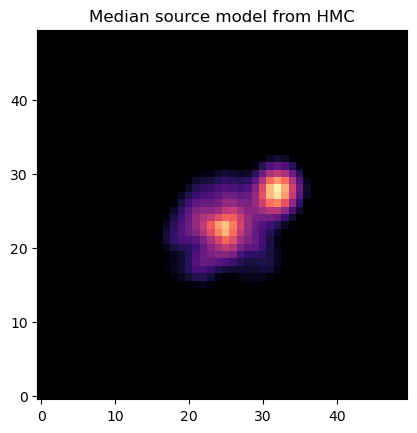

In [50]:
plt.title("Median source model from HMC")
plt.imshow(
    np.median(hmcgibbs_samples_as_kwargs['kwargs_source'][0]['pixels'], axis=0), 
    norm=plotter.norm_flux,
    cmap=plotter.cmap_flux,
)

In [51]:
params_to_corner = [
    'lens_theta_E',
    'light_cx',
    'light_cy',
    'light_e1',
    'light_e2',
    'lens_gamma1',
    'lens_gamma2',
    'source_pixels_field_xy_dim_loglogavgslope',
    'source_pixels_field_zeromode',
    'source_pixels_field_xy_dim_fluctuations',
]
truth_values = {
    'lens_theta_E': kwargs_lens_input[0]['theta_E'],
    'light_cx': kwargs_lens_light_input[0]['center_x'],
    'light_cy': kwargs_lens_light_input[0]['center_y'],
    'light_e1': kwargs_lens_input[0]['e1'],
    'light_e2': kwargs_lens_input[0]['e2'],
    'lens_gamma1': kwargs_lens_input[1]['gamma1'],
    'lens_gamma2': kwargs_lens_input[1]['gamma2'],
    'source_pixels_field_xy_dim_loglogavgslope': None,
    'source_pixels_field_zeromode': None,
    'source_pixels_field_xy_dim_fluctuations': None,
}

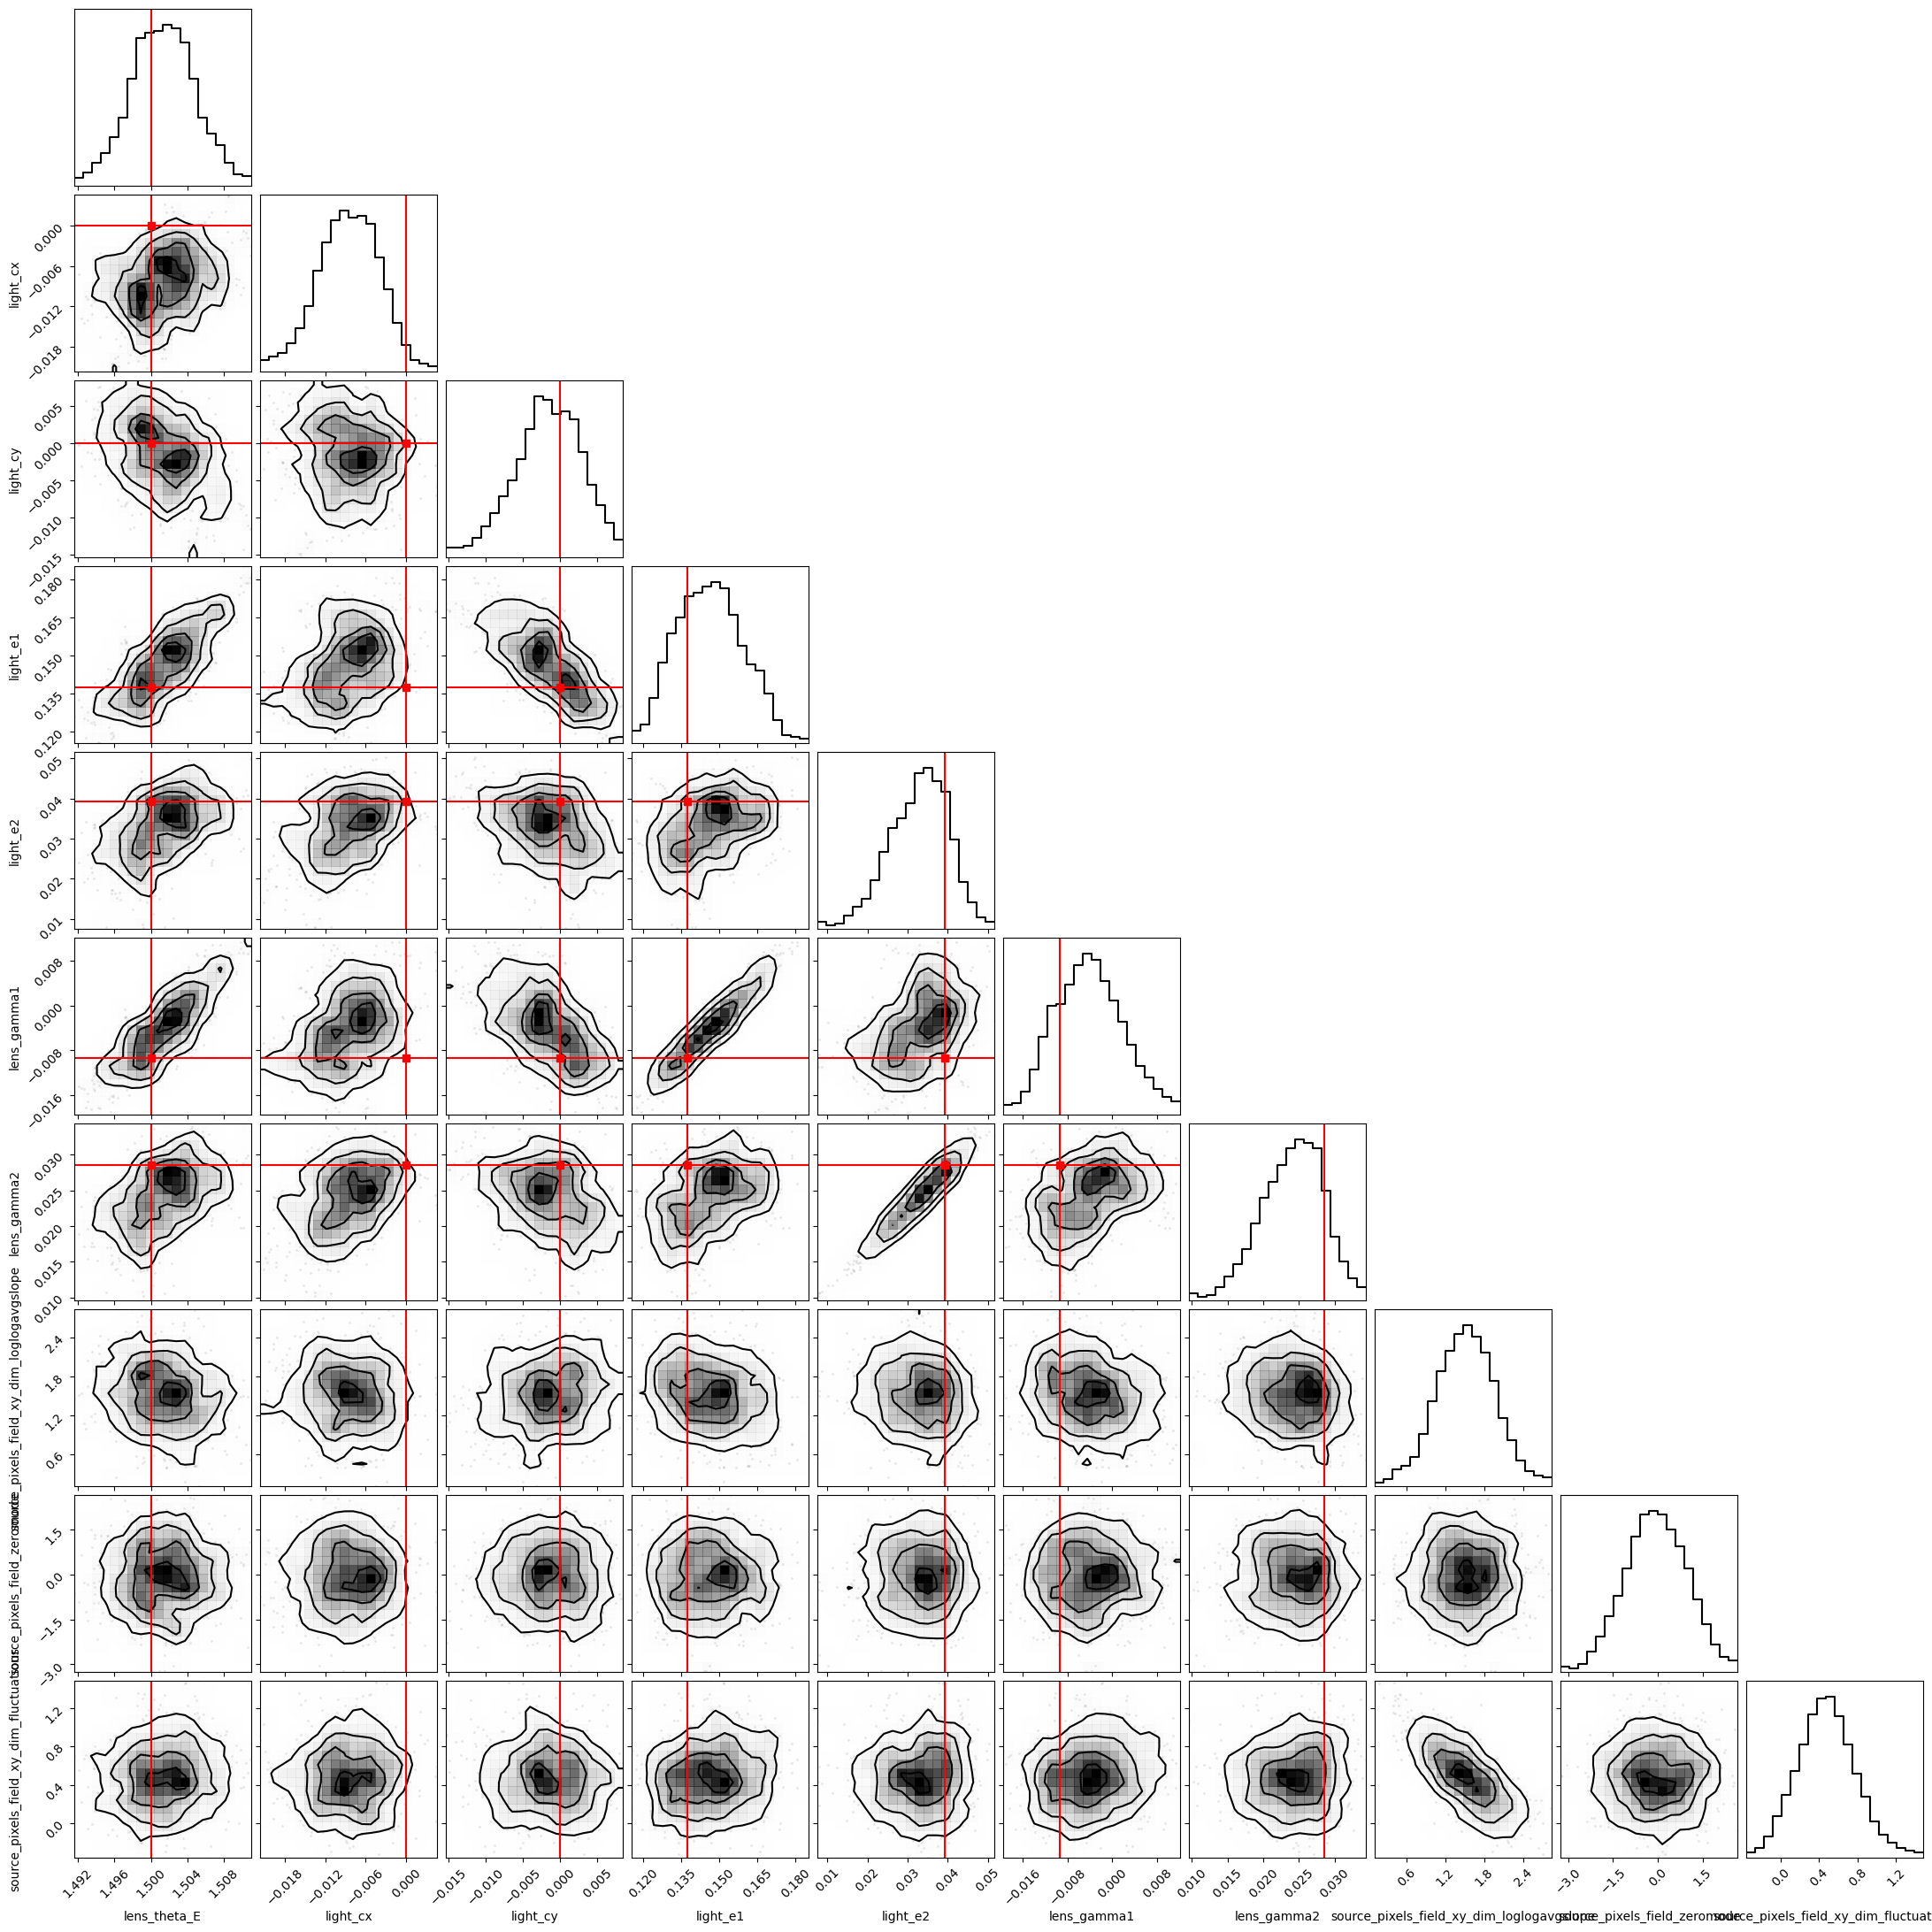

In [52]:

fig = corner.corner(
    inf_data_hmc,
    var_names=params_to_corner,
    color='black',
    truths=[truth_values[p] for p in params_to_corner],
    truth_color='red',
    # smooth the posteriors a bit
    smooth=0.8,
    smooth1d=0.8,
)

In [53]:
if not RUN_MCLMC:
    raise

## Running MCLMC

 Setup the sampler

In [78]:
# decide on the number steps for the two phases of MCLMC
num_steps_tuning = 3_000 if not TEST_MODE else 100  # finding L and step_size
num_steps_sampling = 10_000 if not TEST_MODE else 100  # running the actual sampling

# get RNG keys
prng_key, prng_key_mclmc = jax.random.split(prng_key)
prng_key_model_init, prng_key_mclmc_init, prng_key_mclmc_tuning, prng_key_mclmc_sampling = jax.random.split(prng_key_mclmc, 4)

# prepare the log-density function, initial position and optional transform
median_all_svi_chains = jax.tree.map(lambda x: jnp.median(x, axis=0), hmcgibbs_samples)  # median position from all VI chains
initial_params_gen, potential_fn_gen, *_ = infer.util.initialize_model(
    prng_key_model_init,
    prob_model.model,
    init_strategy=infer.init_to_value(
        values=median_all_svi_chains,  # median position from all VI chains,
    ),
    dynamic_args=False,
)
initial_pos_mclmc = initial_params_gen.z
logdensity_fn_mclmc = lambda x: -potential_fn_gen(x)
transform_mclmc = lambda state, info: (prob_model.constrain(state.position), info)  # so we retrieve the samples directly in constrained space, as well as the "info" which contains the energy history

In [79]:
logdensity_fn_mclmc(initial_pos_mclmc)

Array(26419.71209686, dtype=float64)

Fine-tuning stage

In [80]:
# create an initial state for the sampler
initial_state_before_tuning = blackjax.mcmc.mclmc.init(
    position=initial_pos_mclmc, 
    logdensity_fn=logdensity_fn_mclmc, 
    rng_key=prng_key_mclmc_init,
)

if not SKIP_MCLMC_TUNING:
    # build the kernel
    kernel = lambda inverse_mass_matrix: blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn_mclmc,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        state_after_tuning,
        mclmc_sampler_params,
        _,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps_tuning,
        state=initial_state_before_tuning,
        rng_key=prng_key_mclmc_tuning,

        # new stuff
        desired_energy_var=5e-4,  # just the value from https://blackjax-devs.github.io/sampling-book/algorithms/mclmc.html#id2
        diagonal_preconditioning=False,

        # frac_tune1=0.1,
        # frac_tune2=0.1,
        # frac_tune3=0.,  # TODO: the third step causes problems...
        # trust_in_estimate=1.5,
        # num_effective_samples=150,
    )

    print("mclmc_sampler_params", mclmc_sampler_params)
    L = mclmc_sampler_params.L
    step_size = mclmc_sampler_params.step_size
    initial_state_for_sampling = state_after_tuning

else:
    print("Skipping MCLMC tuning stage.")
    L = 0.1
    step_size = 0.5
    initial_state_for_sampling = initial_state_before_tuning

Skipping MCLMC tuning stage.


In [81]:
print(f"Using the following MCLMC hyperparameters: step_size = {step_size:.2e}, L = {L:.2e}")

# use the quick wrapper to build a new kernel with the tuned parameters
sampling_alg = blackjax.mclmc(
    logdensity_fn_mclmc,
    L=L, step_size=step_size,
)

# run the sampler, it returns (final_state, state_history, info_history)
final_state_mclmc, state_history_mclmc = blackjax.util.run_inference_algorithm(
    rng_key=prng_key_mclmc_sampling,
    initial_state=initial_state_for_sampling,
    inference_algorithm=sampling_alg,
    num_steps=num_steps_sampling,
    transform=transform_mclmc,
    progress_bar=True,
)

# unpack the results
samples_mclmc, info_mclmc = state_history_mclmc

Using the following MCLMC hyperparameters: step_size = 5.00e-01, L = 1.00e-01


(10000,)


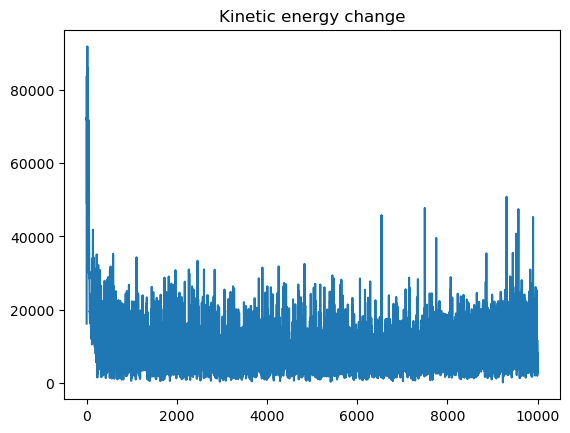

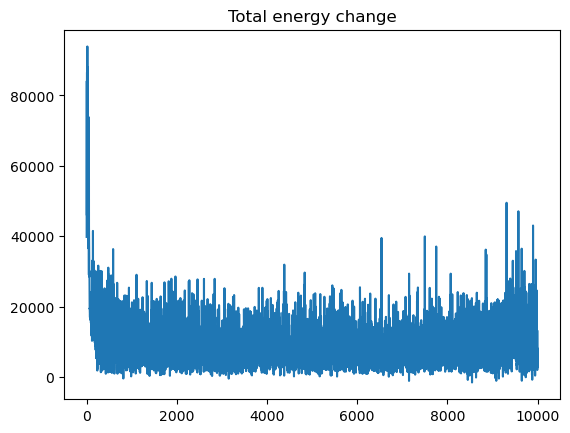

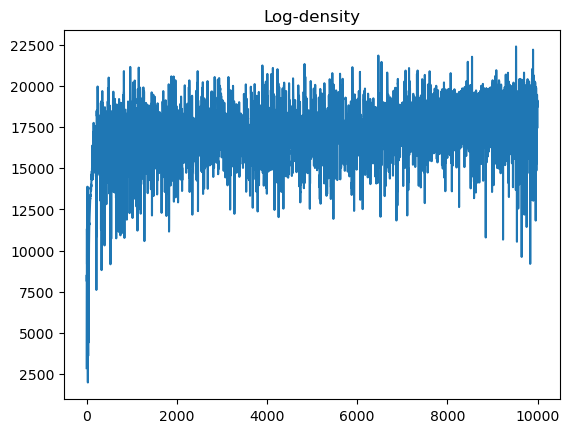

In [82]:
print(info_mclmc.logdensity.shape)

plt.title("Kinetic energy change")
plt.plot(info_mclmc.kinetic_change)
plt.show()

plt.title("Total energy change")
plt.plot(info_mclmc.energy_change)
plt.show()

plt.title("Log-density")
plt.plot(info_mclmc.logdensity)
plt.show()

The following cells using `arviz` have been taken from `blackjax` examples. They take quite some time to run.

Check that the the best fit from the MCLMC chain actually fits well the data.

9522


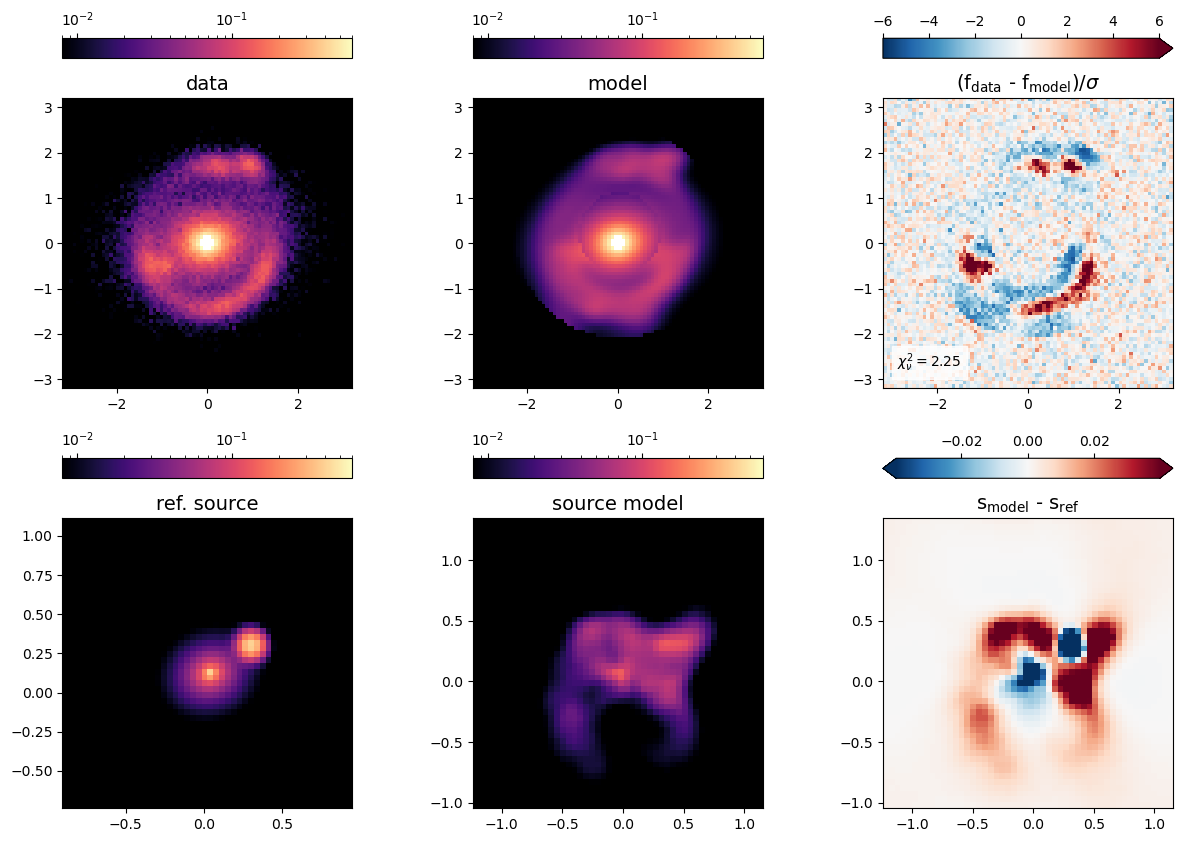

In [103]:
# get the best sample from MCLMC
idx_best_mclmc = np.argmax(info_mclmc.logdensity)
print(idx_best_mclmc)
best_sample_mclmc = get_value_from_index(samples_mclmc, idx_best_mclmc)
kwargs_best_fit_mclmc = prob_model.params2kwargs(best_sample_mclmc)

# plot the model summary
fig = plotter.model_summary(
    lens_image, 
    kwargs_best_fit_mclmc, 
    show_source=True,
)

So, it turns out that MCLMC did not sample the right location in parameter space. This probably due to the step size and L parameters not being optimal, so further work is needed here. In the following comparison, we drop the MCLMC samples.

## Compare the posteriors between all these strategies

In [83]:
# for comparison we also retrieve samples from the probabilistic model prior
prng_key, prng_key_prior = jax.random.split(prng_key)
prior_samples = Predictive(prob_model.model, num_samples=3000)(prng_key_prior)
del prior_samples['obs']

In [84]:
# retrieve samples from the guide posteriors (still in unconstrained space!)
key, key_svi_post, key_svi_prior = jax.random.split(key, 3)
samples_svi_multi_chains = guide_svi.sample_posterior(
    key_svi_post, multi_svi_results.params, 
    sample_shape=(3000,)
)
samples_svi_all_chains = jax.tree.map(lambda x: jnp.concatenate(x, axis=0), samples_svi_multi_chains)

In [99]:
# here are the parameters we will plot
params_to_corner

['lens_theta_E',
 'light_cx',
 'light_cy',
 'light_e1',
 'light_e2',
 'lens_gamma1',
 'lens_gamma2',
 'source_pixels_field_xy_dim_loglogavgslope',
 'source_pixels_field_zeromode',
 'source_pixels_field_xy_dim_fluctuations']

Removed no burn in
Removed no burn in
Removed no burn in
Removed 0.2 as burn in


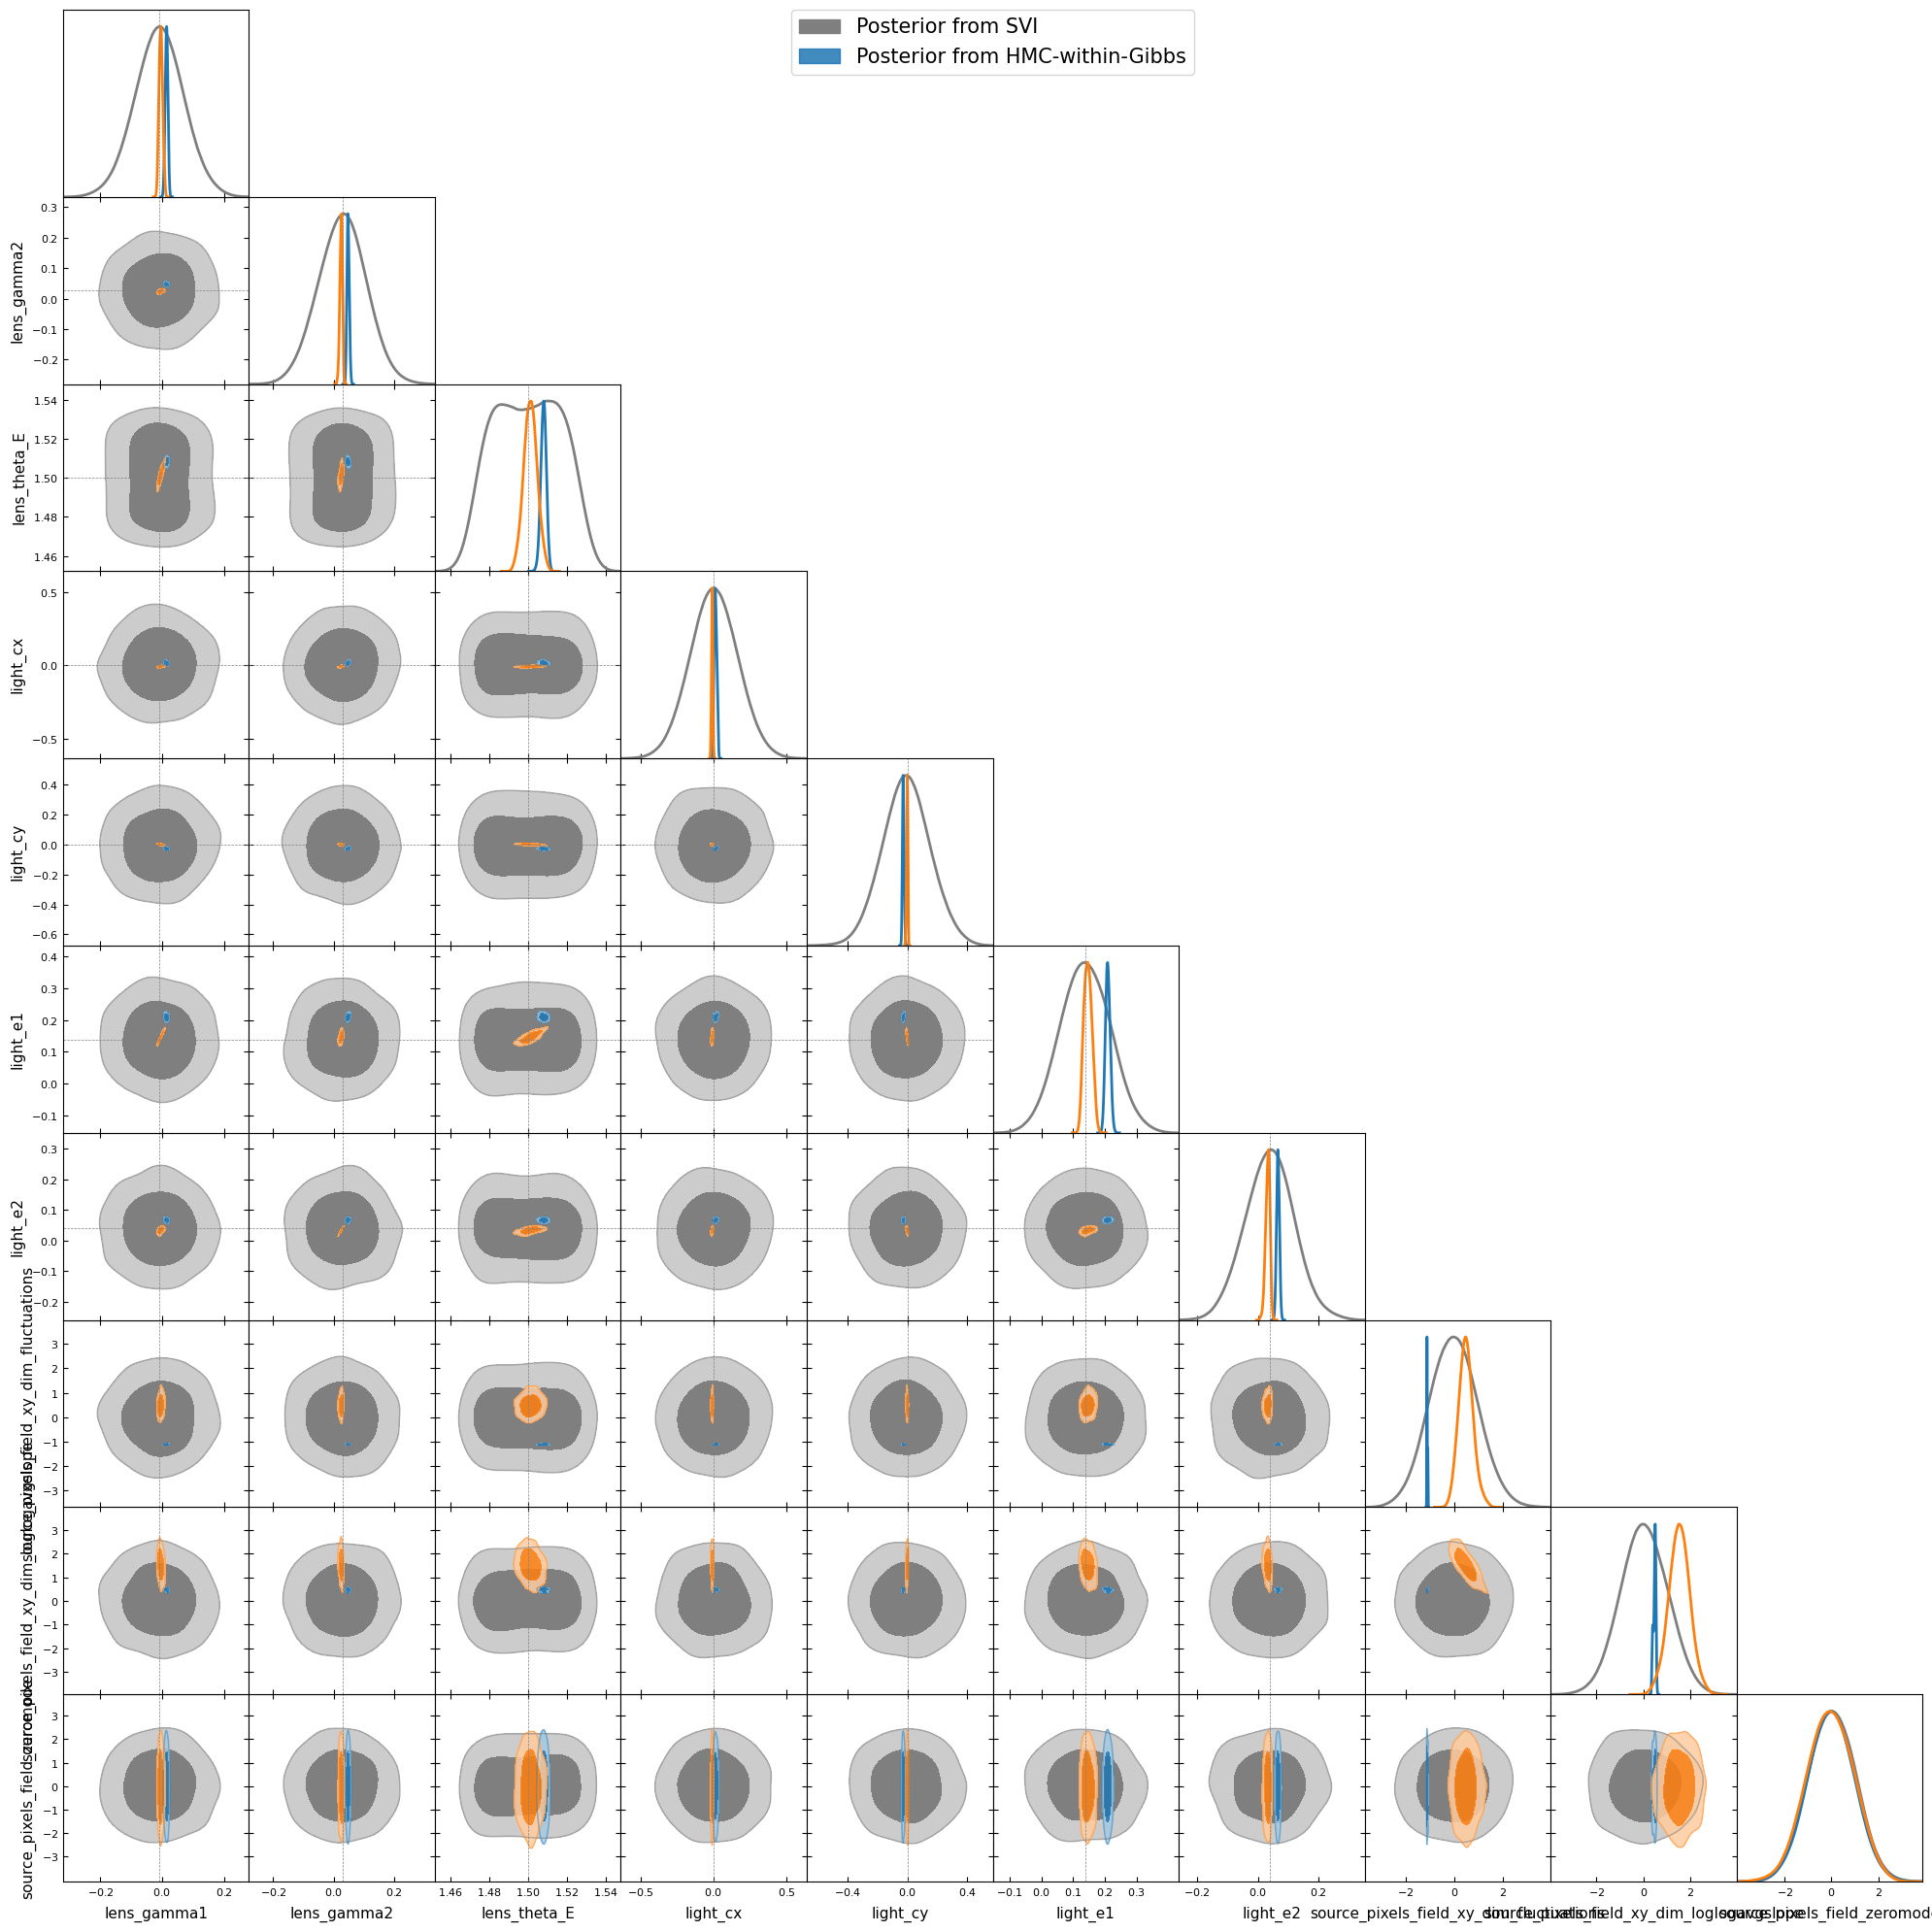

In [104]:
settings_mcsamples = {
    # "ignore_rows": 0.0,
    # "fine_bins_2D": 800,
    "smooth_scale_1D": 0.5,
    "smooth_scale_2D": 0.5,
    # "mult_bias_correction_order": 5
}

names = sorted(params_to_corner)

mcsamples_prior = MCSamples(
    samples=[prior_samples[name] for name in names], 
    names=names, #labels=names, 
    settings=settings_mcsamples,
)
mcsamples_svi = MCSamples(
    samples=[samples_svi_all_chains[name] for name in names], 
    names=names, #labels=names, 
    settings=settings_mcsamples,
)
mcsamples_hmcgibbs = MCSamples(
    samples=[hmcgibbs_samples[name] for name in names], 
    names=names, #labels=names, 
    settings=settings_mcsamples,
)
mcsamples_mclmc = MCSamples(
    samples=[samples_mclmc[name] for name in names], 
    names=names, #labels=names, 
    settings=settings_mcsamples,
    ignore_rows=0.2,  # 20% burnin
)
mcsamples_list = [
    mcsamples_prior,  # uncomment these to show the prior
    mcsamples_svi,
    mcsamples_hmcgibbs,
    # mcsamples_mclmc,
]
colors = [
    "tab:gray",
    "tab:blue",
    "tab:orange",
    # "tab:red",
]
contour_lws = [
    2,
    2,
    2,
    # 2,
]
legend_labels = [
    # "Prior",
    "Posterior from SVI",
    "Posterior from HMC-within-Gibbs",
    # "Posterior from MCLMC",
]

g = plots.get_subplot_plotter(subplot_size=2)
g.settings.legend_fontsize = 18
g.settings.axes_labelsize = 14 
g.triangle_plot(
    mcsamples_list,
    params=names,
    legend_labels=legend_labels,
    filled=True,
    colors=colors,
    contour_colors=colors,
    markers=[truth_values[name] for name in names],
    # line_args=line_args,   # TODO: issue that linewidth settings in line_args are being overwritten by contour_lws
    contour_lws=contour_lws,
    # contour_ls=contour_ls,
    # alphas=alphas,
)

NOTE: We see above that the MCLMC shows significantly different posteriors than with other sampling strategies.

## Compare best-fit and median source models

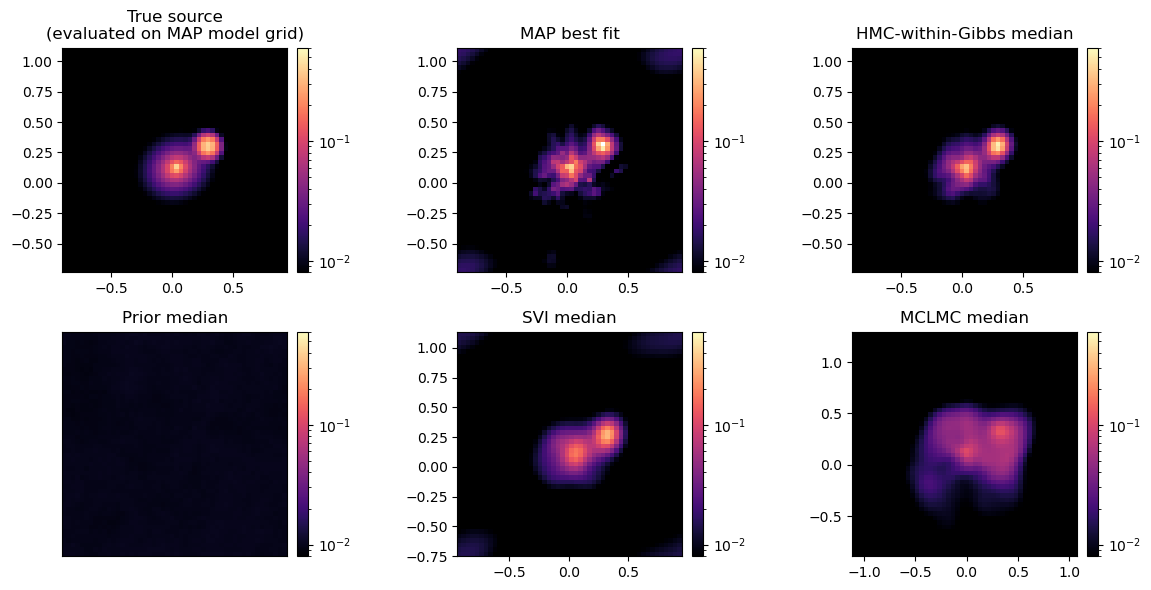

In [98]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

ax = axes[0, 0]
ax.set_title("True source\n(evaluated on MAP model grid)")
ax.imshow(
    source_input_on_model_grid, 
    norm=plotter.norm_flux, 
    cmap=plotter.cmap_flux, 
    extent=src_extent,
)

ax = axes[1, 0]
ax.set_title("Prior median")
# get the median from the prior samples
prng_key, prng_key_source_real = jax.random.split(prng_key)
source_prior_median = jnp.median(
    source_field.draw_realizations_from_prior(prng_key_source_real, num_samples=3_000), axis=0,
)
ax.imshow(
    source_prior_median, 
    norm=plotter.norm_flux, 
    cmap=plotter.cmap_flux, 
    extent=None,  # there is no lens model so we don't know the extent of the source plane
)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[0, 1]
ax.set_title("MAP best fit")
kwargs_best_fit_optim = prob_model.params2kwargs(best_fit_optim)
ax.imshow(
    kwargs_best_fit_optim['kwargs_source'][0]['pixels'],
    norm=plotter.norm_flux,
    cmap=plotter.cmap_flux,
    extent=src_extent,
)

ax = axes[1, 1]
ax.set_title("SVI median")
idx_svi_chain = 0
kwargs_svi_single_chain_median = prob_model.params2kwargs(get_value_from_index(multi_svi_median, idx_svi_chain))
_, _, src_extent_svi = lens_image.get_source_coordinates(
    kwargs_lens=kwargs_svi_single_chain_median['kwargs_lens'],
    return_plt_extent=True,
)
ax.imshow(
    kwargs_svi_single_chain_median['kwargs_source'][0]['pixels'],
    norm=plotter.norm_flux,
    cmap=plotter.cmap_flux,
    extent=src_extent_svi,
)

ax = axes[0, 2]
ax.set_title("HMC-within-Gibbs median")
kwargs_hmcgibbs_median = prob_model.params2kwargs(jax.tree.map(lambda x: jnp.median(x, axis=0), hmcgibbs_samples))
_, _, src_extent_hmcgibbs = lens_image.get_source_coordinates(
    kwargs_lens=kwargs_hmcgibbs_median['kwargs_lens'],
    return_plt_extent=True,
)
ax.imshow(
    kwargs_hmcgibbs_median['kwargs_source'][0]['pixels'],
    norm=plotter.norm_flux,
    cmap=plotter.cmap_flux,
    extent=src_extent_hmcgibbs,
)

ax = axes[1, 2]
ax.set_title("MCLMC median")
kwargs_mclmc_median = prob_model.params2kwargs(jax.tree.map(lambda x: jnp.median(x, axis=0), samples_mclmc))
kwargs_mclmc_mean = prob_model.params2kwargs(jax.tree.map(lambda x: jnp.mean(x, axis=0), samples_mclmc))
kwargs_mclmc_std = prob_model.params2kwargs(jax.tree.map(lambda x: jnp.std(x, axis=0), samples_mclmc))
_, _, src_extent_mclmc = lens_image.get_source_coordinates(
    kwargs_lens=kwargs_mclmc_median['kwargs_lens'],
    return_plt_extent=True,
)
ax.imshow(
    kwargs_mclmc_median['kwargs_source'][0]['pixels'],
    # kwargs_mclmc_mean['kwargs_source'][0]['pixels'],
    # kwargs_mclmc_median['kwargs_source'][0]['pixels'] / kwargs_mclmc_std['kwargs_source'][0]['pixels'],
    norm=plotter.norm_flux,
    cmap=plotter.cmap_flux,
    extent=src_extent_mclmc,
)

# Add colorbars
for ax in axes.flatten():
    try:
        plot_util.nice_colorbar(ax.get_images()[0])
    except:
        pass

fig.tight_layout()
plt.show()

## Trying out nested sampling with `JAXNS`

The following sample does not work well for our purposes, but if you have an idea, let me know ;-)